# Piecewise Interrupted Time Series (Segmented Regression)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import causalpy as cp
from causalpy.data.simulate_data import generate_piecewise_its_data

%config InlineBackend.figure_format = 'retina'

Did your marketing campaign actually work? When a hospital implements a new safety protocol, how much of the improvement is due to the intervention versus the existing trend? If a policy changed at a known date, can you quantify both the immediate impact and any lasting change in trajectory?

These are the questions that **Piecewise Interrupted Time Series** (also known as **segmented regression**) is designed to answer. This method allows you to estimate causal effects when you have time series data and interventions that occurred at **known time points**.

## When to Use Piecewise ITS

Piecewise ITS is appropriate when you have time series data and want to evaluate the impact of one or more interventions that occurred at **known time points**. The method is particularly useful depending on what type of effect you expect.

Some interventions cause **level changes**—the outcome jumps up or down immediately at the intervention time. Think of tax rate changes that immediately affect prices, product price adjustments that cause instant drops in sales, policy announcements where compliance begins right away, or one-time events like natural disasters or product recalls.

Other interventions cause **slope changes** (trend breaks), where the rate of change shifts after the intervention but without an immediate jump. Educational programs that gradually improve worker productivity, infrastructure improvements like new highways that slowly reduce commute times, phased regulatory rollouts, and public awareness campaigns that slowly shift behavior all fall into this category.

Many real-world interventions cause **both** an immediate effect and a sustained change in trajectory. A new hospital protocol might immediately reduce infection rates while also continuing to improve outcomes as staff become more proficient. A marketing campaign might spike sales at launch while also building sustained momentum. A policy reform might have immediate compliance effects alongside long-term behavioral changes.

## Key Concepts: Level Changes and Slope Changes

Understanding the difference between level changes and slope changes is fundamental to using piecewise ITS effectively. The figure below illustrates these concepts for both single and multiple interventions.

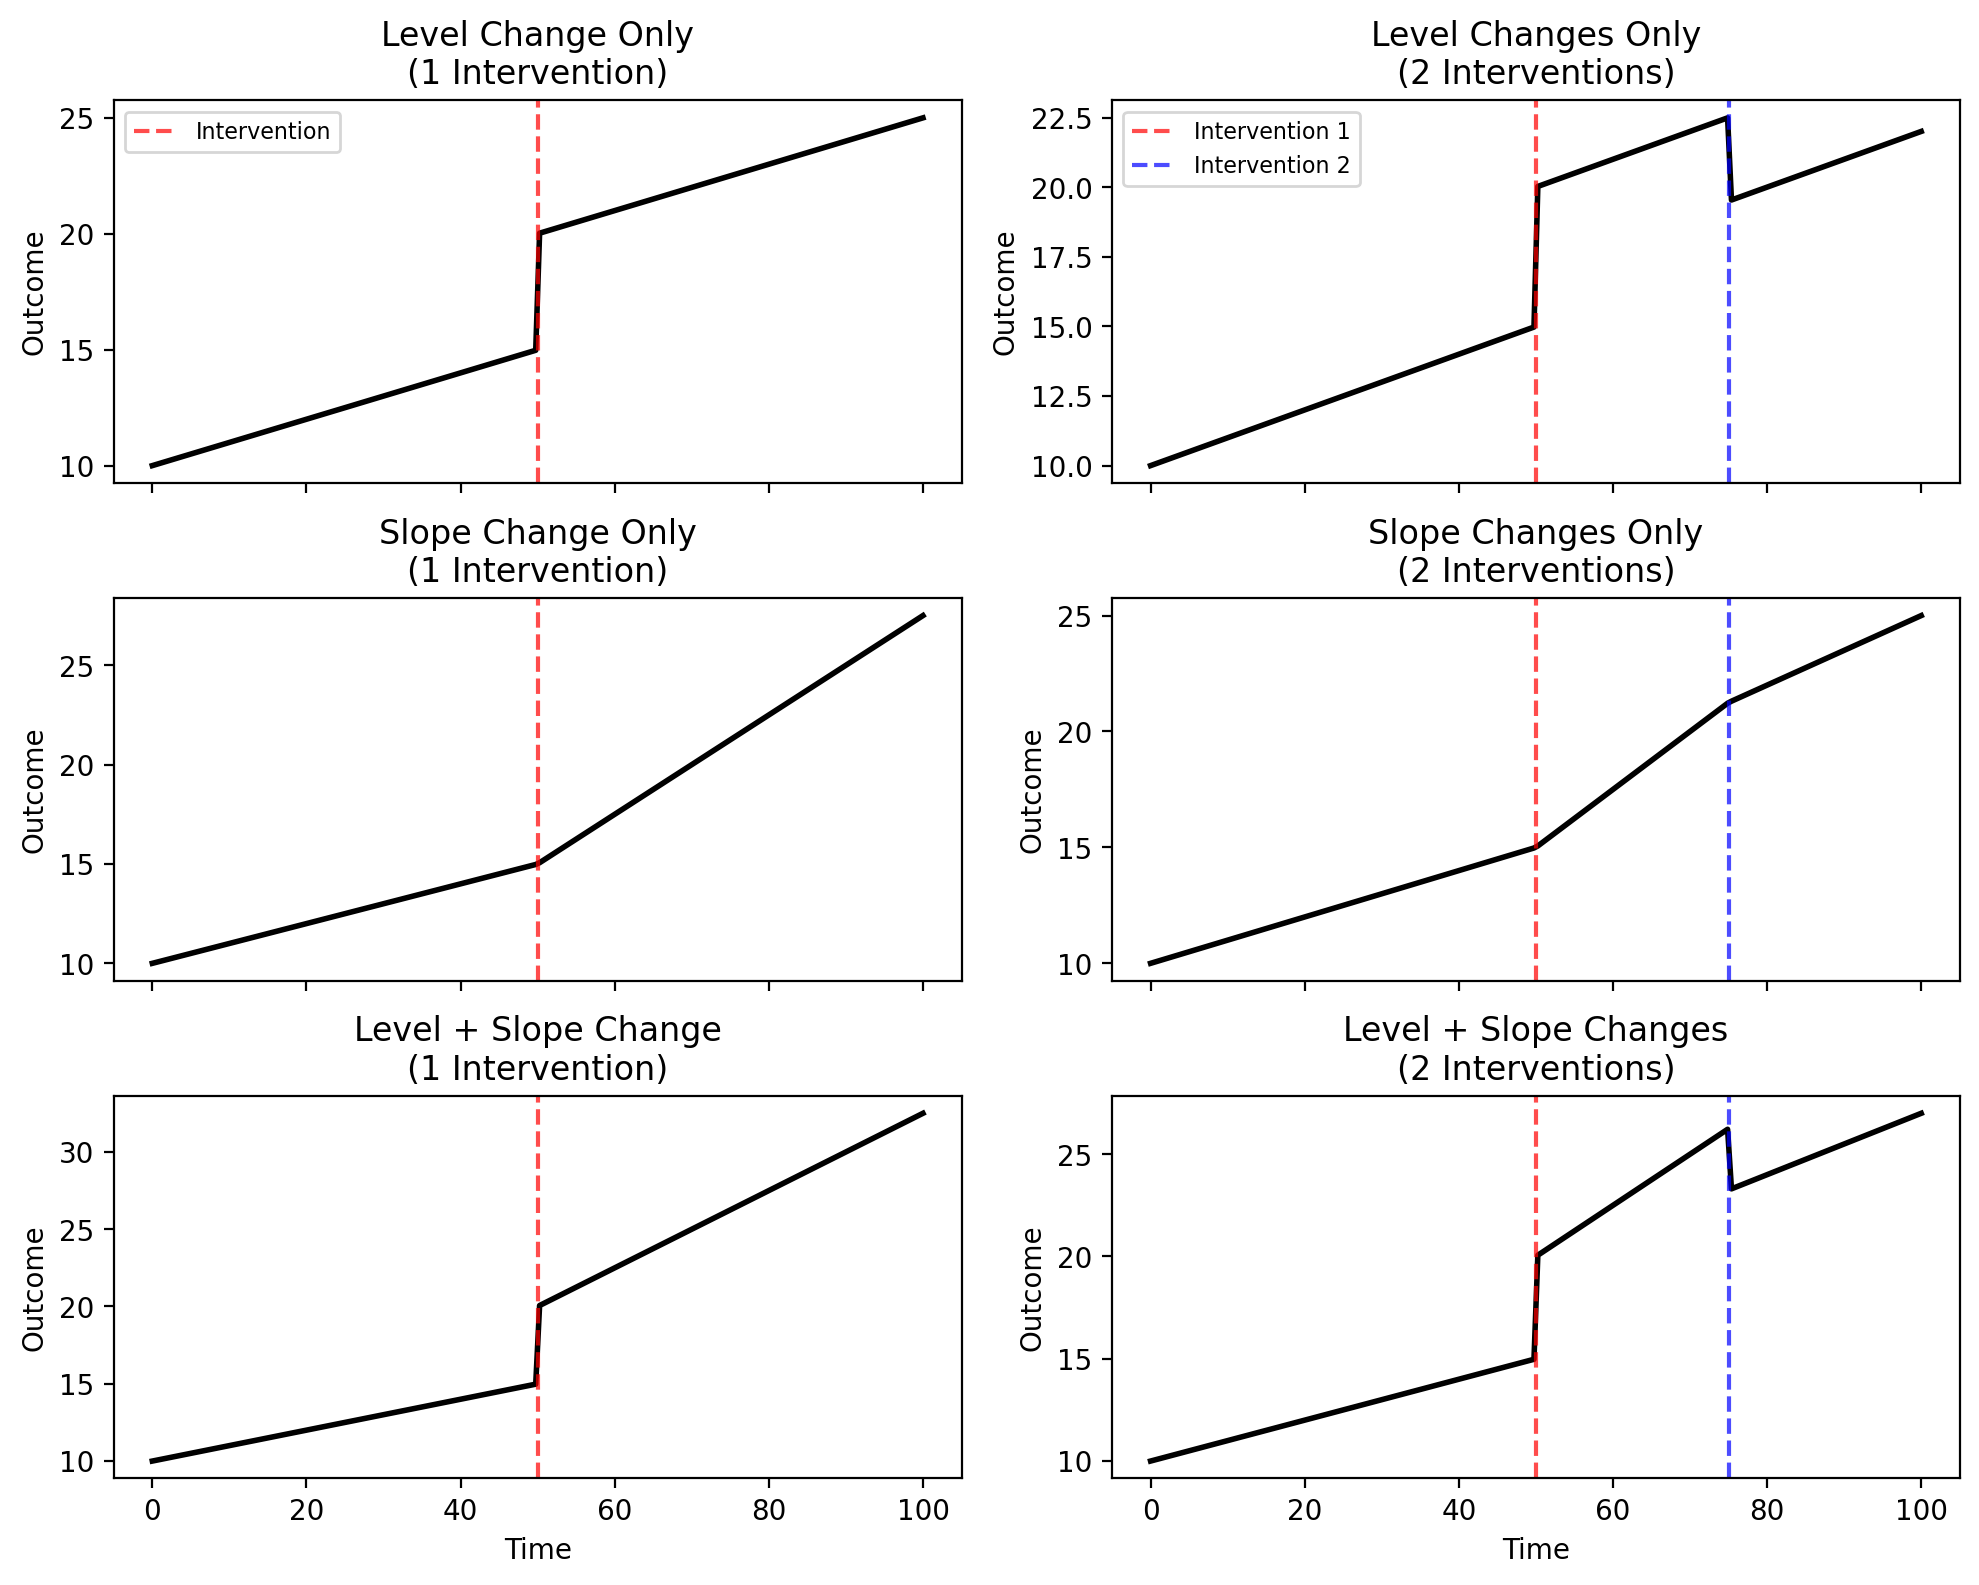

In [2]:
# Visualize different combinations of level and slope changes
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=True)

t = np.linspace(0, 100, 200)
t1, t2 = 50, 75  # Intervention times


# Helper functions
def step(t, threshold):
    return (t >= threshold).astype(float)


def ramp(t, threshold):
    return np.maximum(0, t - threshold)


# Baseline parameters
intercept, slope = 10, 0.1
level_change, slope_change = 5, 0.15
level_change2, slope_change2 = -3, -0.1

# Row 0: Level change only
# Single intervention
y = intercept + slope * t + level_change * step(t, t1)
axes[0, 0].plot(t, y, "k-", lw=2)
axes[0, 0].axvline(t1, color="red", linestyle="--", alpha=0.7, label="Intervention")
axes[0, 0].set_title("Level Change Only\n(1 Intervention)")
axes[0, 0].legend(loc="upper left", fontsize=8)

# Two interventions
y = intercept + slope * t + level_change * step(t, t1) + level_change2 * step(t, t2)
axes[0, 1].plot(t, y, "k-", lw=2)
axes[0, 1].axvline(t1, color="red", linestyle="--", alpha=0.7, label="Intervention 1")
axes[0, 1].axvline(t2, color="blue", linestyle="--", alpha=0.7, label="Intervention 2")
axes[0, 1].set_title("Level Changes Only\n(2 Interventions)")
axes[0, 1].legend(loc="upper left", fontsize=8)

# Row 1: Slope change only
# Single intervention
y = intercept + slope * t + slope_change * ramp(t, t1)
axes[1, 0].plot(t, y, "k-", lw=2)
axes[1, 0].axvline(t1, color="red", linestyle="--", alpha=0.7)
axes[1, 0].set_title("Slope Change Only\n(1 Intervention)")

# Two interventions
y = intercept + slope * t + slope_change * ramp(t, t1) + slope_change2 * ramp(t, t2)
axes[1, 1].plot(t, y, "k-", lw=2)
axes[1, 1].axvline(t1, color="red", linestyle="--", alpha=0.7)
axes[1, 1].axvline(t2, color="blue", linestyle="--", alpha=0.7)
axes[1, 1].set_title("Slope Changes Only\n(2 Interventions)")

# Row 2: Both level and slope change
# Single intervention
y = intercept + slope * t + level_change * step(t, t1) + slope_change * ramp(t, t1)
axes[2, 0].plot(t, y, "k-", lw=2)
axes[2, 0].axvline(t1, color="red", linestyle="--", alpha=0.7)
axes[2, 0].set_title("Level + Slope Change\n(1 Intervention)")
axes[2, 0].set_xlabel("Time")

# Two interventions
y = (
    intercept
    + slope * t
    + level_change * step(t, t1)
    + slope_change * ramp(t, t1)
    + level_change2 * step(t, t2)
    + slope_change2 * ramp(t, t2)
)
axes[2, 1].plot(t, y, "k-", lw=2)
axes[2, 1].axvline(t1, color="red", linestyle="--", alpha=0.7)
axes[2, 1].axvline(t2, color="blue", linestyle="--", alpha=0.7)
axes[2, 1].set_title("Level + Slope Changes\n(2 Interventions)")
axes[2, 1].set_xlabel("Time")

for ax in axes.flat:
    ax.set_ylabel("Outcome")

plt.tight_layout()
plt.show()

:::{dropdown} Model formulas for each panel (click to expand)
Jumping a little ahead, here is a sneak peek into the flexible API we've got for piecewise regression. The table below shows the `patsy` model formulas for each panel:

| Effect Type | Single Intervention (Left Column) | Two Interventions (Right Column) |
|-------------|-----------------------------------|----------------------------------|
| **Level only** | `y ~ 1 + t + step(t, 50)` | `y ~ 1 + t + step(t, 50) + step(t, 75)` |
| **Slope only** | `y ~ 1 + t + ramp(t, 50)` | `y ~ 1 + t + ramp(t, 50) + ramp(t, 75)` |
| **Level + Slope** | `y ~ 1 + t + step(t, 50) + ramp(t, 50)` | `y ~ 1 + t + step(t, 50) + ramp(t, 50) + step(t, 75) + ramp(t, 75)` |

You can extend these formulas with additional predictors as needed—for example, to account for seasonality, day-of-week effects, or other drivers of your outcome variable.
:::

A **level change** (or step change) is an immediate, discrete shift in the outcome at the moment of intervention (top row). Before the intervention, the outcome follows one trajectory; at the intervention time, it jumps up or down to a new level. Mathematically, this is captured by a step function that equals 0 before the intervention and 1 after.

A **slope change** (or trend break) is a change in the *rate* at which the outcome evolves over time (middle row). The outcome doesn't necessarily jump at the intervention, but from that point forward, it increases or decreases at a different rate than before. Mathematically, this is captured by a ramp function that equals 0 before the intervention and increases linearly after.

When **both effects occur together**, the outcome jumps at the intervention time *and* continues along a new trajectory with a different slope (bottom row). This is the most common pattern in real-world interventions.

## Multiple Interventions

The piecewise ITS framework extends naturally to **multiple intervention points** (right column in the figure below). If your time series includes several policy changes, sequential rollouts, or distinct events, you can model each one with its own level and/or slope change. This flexibility allows you to isolate the effects of individual interventions even when they occur at different times in the same series.


## Key Differences from other quasi-experimental approaches

The standard {class}`~causalpy.InterruptedTimeSeries` approach fits a model to **pre-intervention data only** and then forecasts a counterfactual for the post-intervention period. This works well when you have a single intervention and sufficient pre-intervention data to establish the baseline trend.

In contrast, `PiecewiseITS` fits a **single model to the entire time series**, explicitly estimating level and/or slope changes at each interruption point. This approach:
- Handles multiple interventions naturally
- Uses all available data for parameter estimation
- Provides direct estimates of intervention effects as model coefficients

Piecewise ITS shares structural similarities with {class}`~causalpy.RegressionDiscontinuity` (RD) and {class}`~causalpy.RegressionKink` (RK) designs—all three methods model discontinuities or changes in relationships at known thresholds. The key difference is the dimension they operate on. RD and RK use a **running variable** to determine treatment assignment (e.g., age, test scores, income thresholds). Piecewise ITS, by contrast, focuses on **time** as the dimension of interest. In short: RD/RK ask "what happens when units cross a threshold in some variable?", while Piecewise ITS asks "what happens to our outcome over time when an intervention occurs?"


## The Piecewise ITS Model

The general piecewise ITS model for $K$ interventions is:

$$y_t = \beta_0 + \beta_1 t + \sum_{k=1}^{K} \left( \delta_k \cdot \text{step}(t, T_k) + \gamma_k \cdot \text{ramp}(t, T_k) \right) + \epsilon_t$$

Where:
- $\beta_0$ is the baseline intercept
- $\beta_1$ is the baseline slope (pre-intervention trend)
- $T_k$ is the time of the $k$-th intervention
- $\delta_k$ is the **level change** at intervention $k$
- $\gamma_k$ is the **slope change** at intervention $k$
- $\epsilon_t$ is the error term

The **step** and **ramp** functions are defined as:

$$\text{step}(t, T) = \mathbf{1}_{t \geq T} = \begin{cases} 1 & \text{if } t \geq T \\ 0 & \text{otherwise} \end{cases}$$

$$\text{ramp}(t, T) = \max(0, t - T) = \begin{cases} t - T & \text{if } t \geq T \\ 0 & \text{otherwise} \end{cases}$$

## Formula-Based API with step() and ramp() Transforms

`PiecewiseITS` uses a patsy formula with custom `step()` and `ramp()` transforms that directly implement the mathematical functions above.

Both transforms take two arguments:
1. **First argument**: The name of the column in your dataset that represents time (e.g., `t`, `date`, `week`)
2. **Second argument**: The time $T$ at which the intervention occurs (the threshold)

Both arguments can be either **numeric** (e.g., `step(t, 50)`) or **datetime** (e.g., `step(date, '2020-06-01')`). For datetime thresholds, you can use string representations like `'2020-06-01'` which will be automatically parsed.

This approach provides maximum flexibility—you can specify different combinations of step and ramp for each intervention. For example:
- Level change only at t=50: `step(t, 50)`
- Slope change only at t=50: `ramp(t, 50)`
- Both level and slope change: `step(t, 50) + ramp(t, 50)`
- Different effects per intervention: `step(t, 50) + step(t, 100) + ramp(t, 100)`
- With datetime: `step(date, '2020-06-01') + ramp(date, '2020-06-01')`

## How the Counterfactual is Computed

The design matrix includes columns for the baseline intercept, a time trend, step functions (for level changes), ramp functions (for slope changes), and any additional control variables you specify in the formula.

Once the model is fitted, the counterfactual is computed by setting all step and ramp columns to zero. Predicting with this modified design matrix gives us the outcome trajectory that would have occurred under the baseline trend alone—as if the interventions had never happened. The causal effect at each time point is simply the difference between the fitted values and this counterfactual.


## Example 1: Single Intervention with Level + Slope Change

The most common piecewise ITS scenario involves a single intervention that causes both an immediate **level shift** (step change) and a change in the **slope** (trend change).

:::{card} Scenario: Hospital Patient Safety Protocol
Consider a hospital that implements a new patient safety protocol at week 50 of a 100-week observation period. The hospital tracks a composite "patient safety score" that measures adverse events, near-misses, and compliance metrics.

Before the intervention (weeks 0-49), patient safety scores follow a baseline trend, slowly improving at about 0.1 points per week due to ongoing quality initiatives and natural learning.

At the intervention (week 50), the new protocol is implemented. Staff receive training, new checklists are introduced, and monitoring increases. We expect an immediate level shift of approximately +5 points as the most obvious safety gaps are addressed right away.

After the intervention (weeks 50-99), the safety improvements continue, but now at a faster rate. The slope increases by about 0.15 points per week as staff internalize the new practices and discover additional efficiencies.

The counterfactual (shown as a dashed line in our plots) represents what would have happened without the intervention—just the original slow improvement continuing. The causal effect is the difference between observed outcomes and this counterfactual, quantifying both the immediate and cumulative impact.
:::

We specify this model using a patsy formula with `step()` and `ramp()` transforms:

```python
formula = "y ~ 1 + t + step(t, 50) + ramp(t, 50)"
```

This corresponds to the model:

$$y_t = \beta_0 + \beta_1 t + \beta_2 \cdot \text{step}(t, 50) + \beta_3 \cdot \text{ramp}(t, 50) + \epsilon_t$$

Where $\beta_2$ captures the immediate level change and $\beta_3$ captures the slope change.


In [3]:
# Generate synthetic data with known parameters
df1, params1 = generate_piecewise_its_data(
    N=100,
    interruption_times=[50],
    baseline_intercept=10.0,
    baseline_slope=0.1,
    level_changes=[5.0],  # Immediate level shift of 5 units
    slope_changes=[0.15],  # Slope increases by 0.15 per time unit
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params1['baseline_intercept']}")
print(f"  Baseline slope: {params1['baseline_slope']}")
print(f"  Level change: {params1['level_changes'][0]}")
print(f"  Slope change: {params1['slope_changes'][0]}")

df1.head()

True parameters:
  Baseline intercept: 10.0
  Baseline slope: 0.1
  Level change: 5.0
  Slope change: 0.15


,t,y,y_true,counterfactual,effect
0,0,10.496714,10.0,10.0,0.0
1,1,9.961736,10.1,10.1,0.0
2,2,10.847689,10.2,10.2,0.0
3,3,11.823030,10.3,10.3,0.0
4,4,10.165847,10.4,10.4,0.0


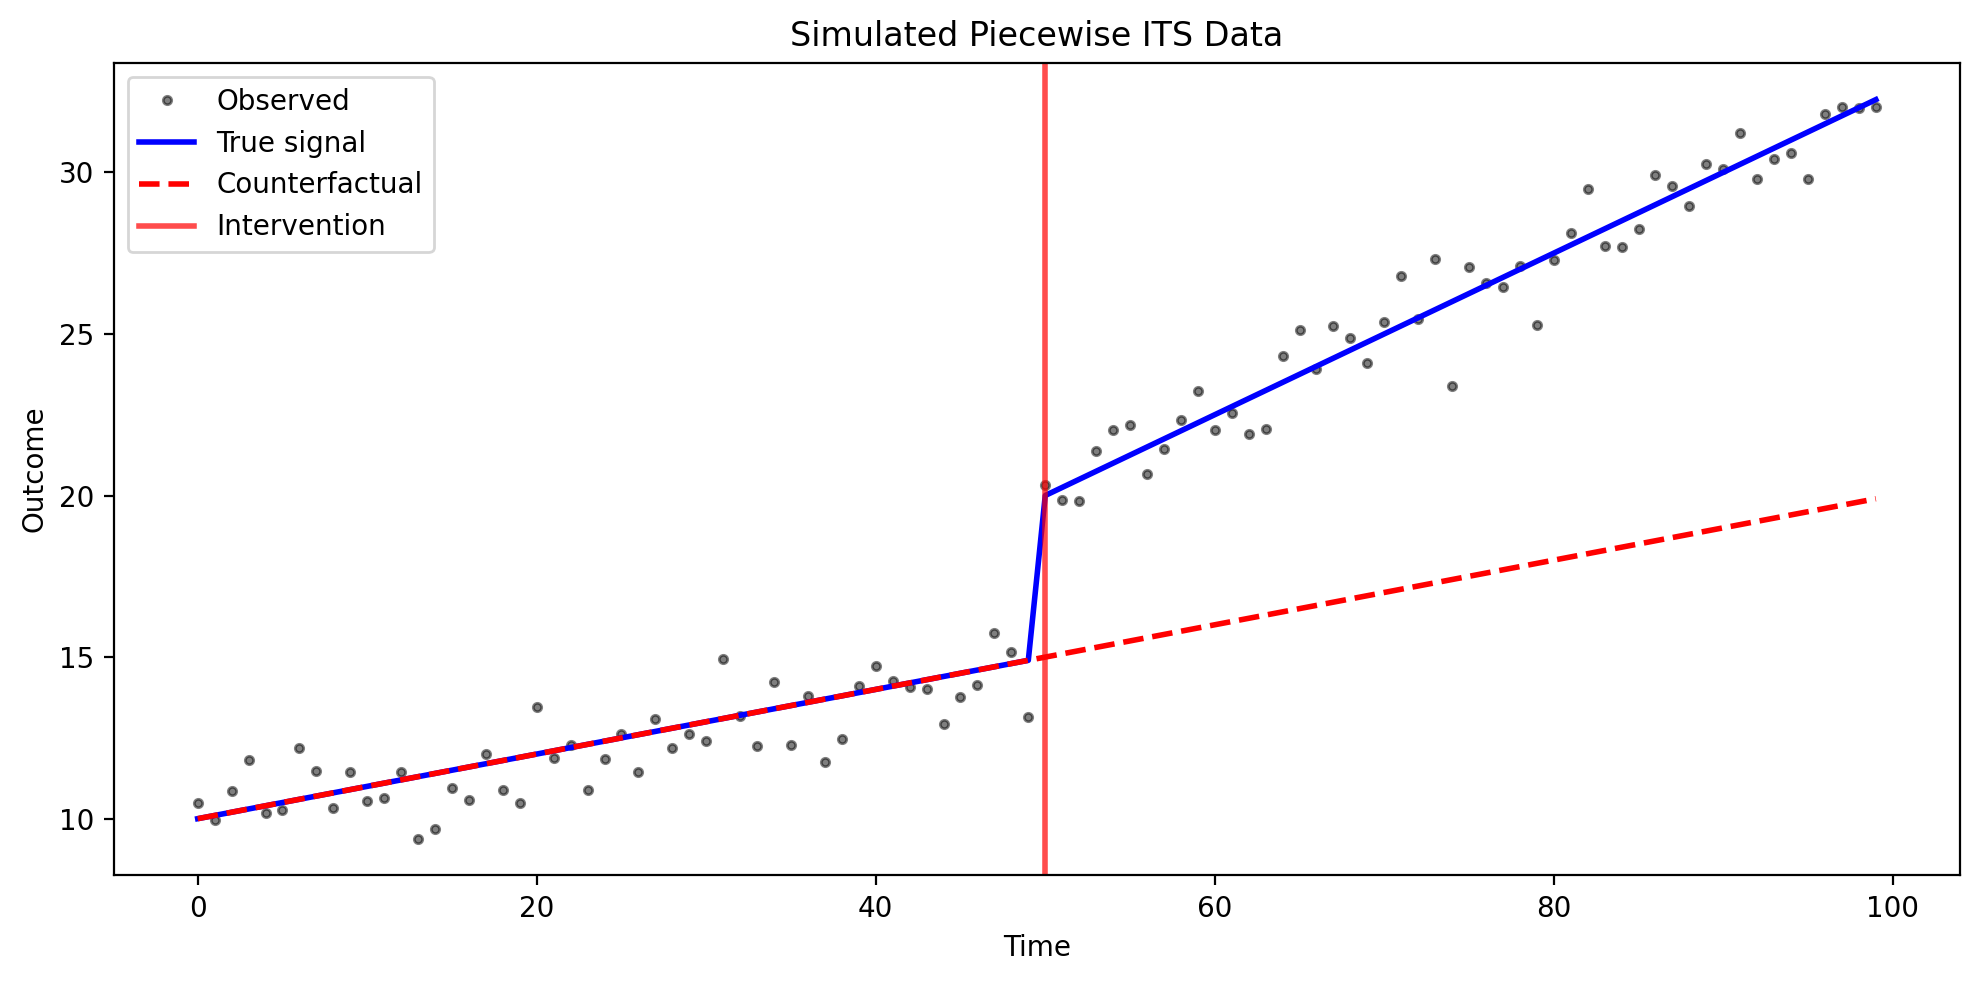

In [4]:
# Visualize the raw data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df1["t"], df1["y"], "k.", alpha=0.5, label="Observed")
ax.plot(df1["t"], df1["y_true"], "b-", lw=2, label="True signal")
ax.plot(df1["t"], df1["counterfactual"], "r--", lw=2, label="Counterfactual")
ax.axvline(x=50, color="red", ls="-", lw=2, alpha=0.7, label="Intervention")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome")
ax.set_title("Simulated Piecewise ITS Data")
ax.legend()
plt.tight_layout()

In [5]:
# Fit the PiecewiseITS model with PyMC
result1 = cp.PiecewiseITS(
    df1,
    formula="y ~ 1 + t + step(t, 50) + ramp(t, 50)",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [6]:
# Display model summary
result1.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + t + step(t, 50) + ramp(t, 50)
Interruption times: [50]
Model coefficients:
    Intercept    10, 94% HDI [9.6, 11]
    t            0.088, 94% HDI [0.072, 0.1]
    step(t, 50)  5.7, 94% HDI [5, 6.4]
    ramp(t, 50)  0.16, 94% HDI [0.13, 0.18]
    y_hat_sigma  0.91, 94% HDI [0.8, 1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


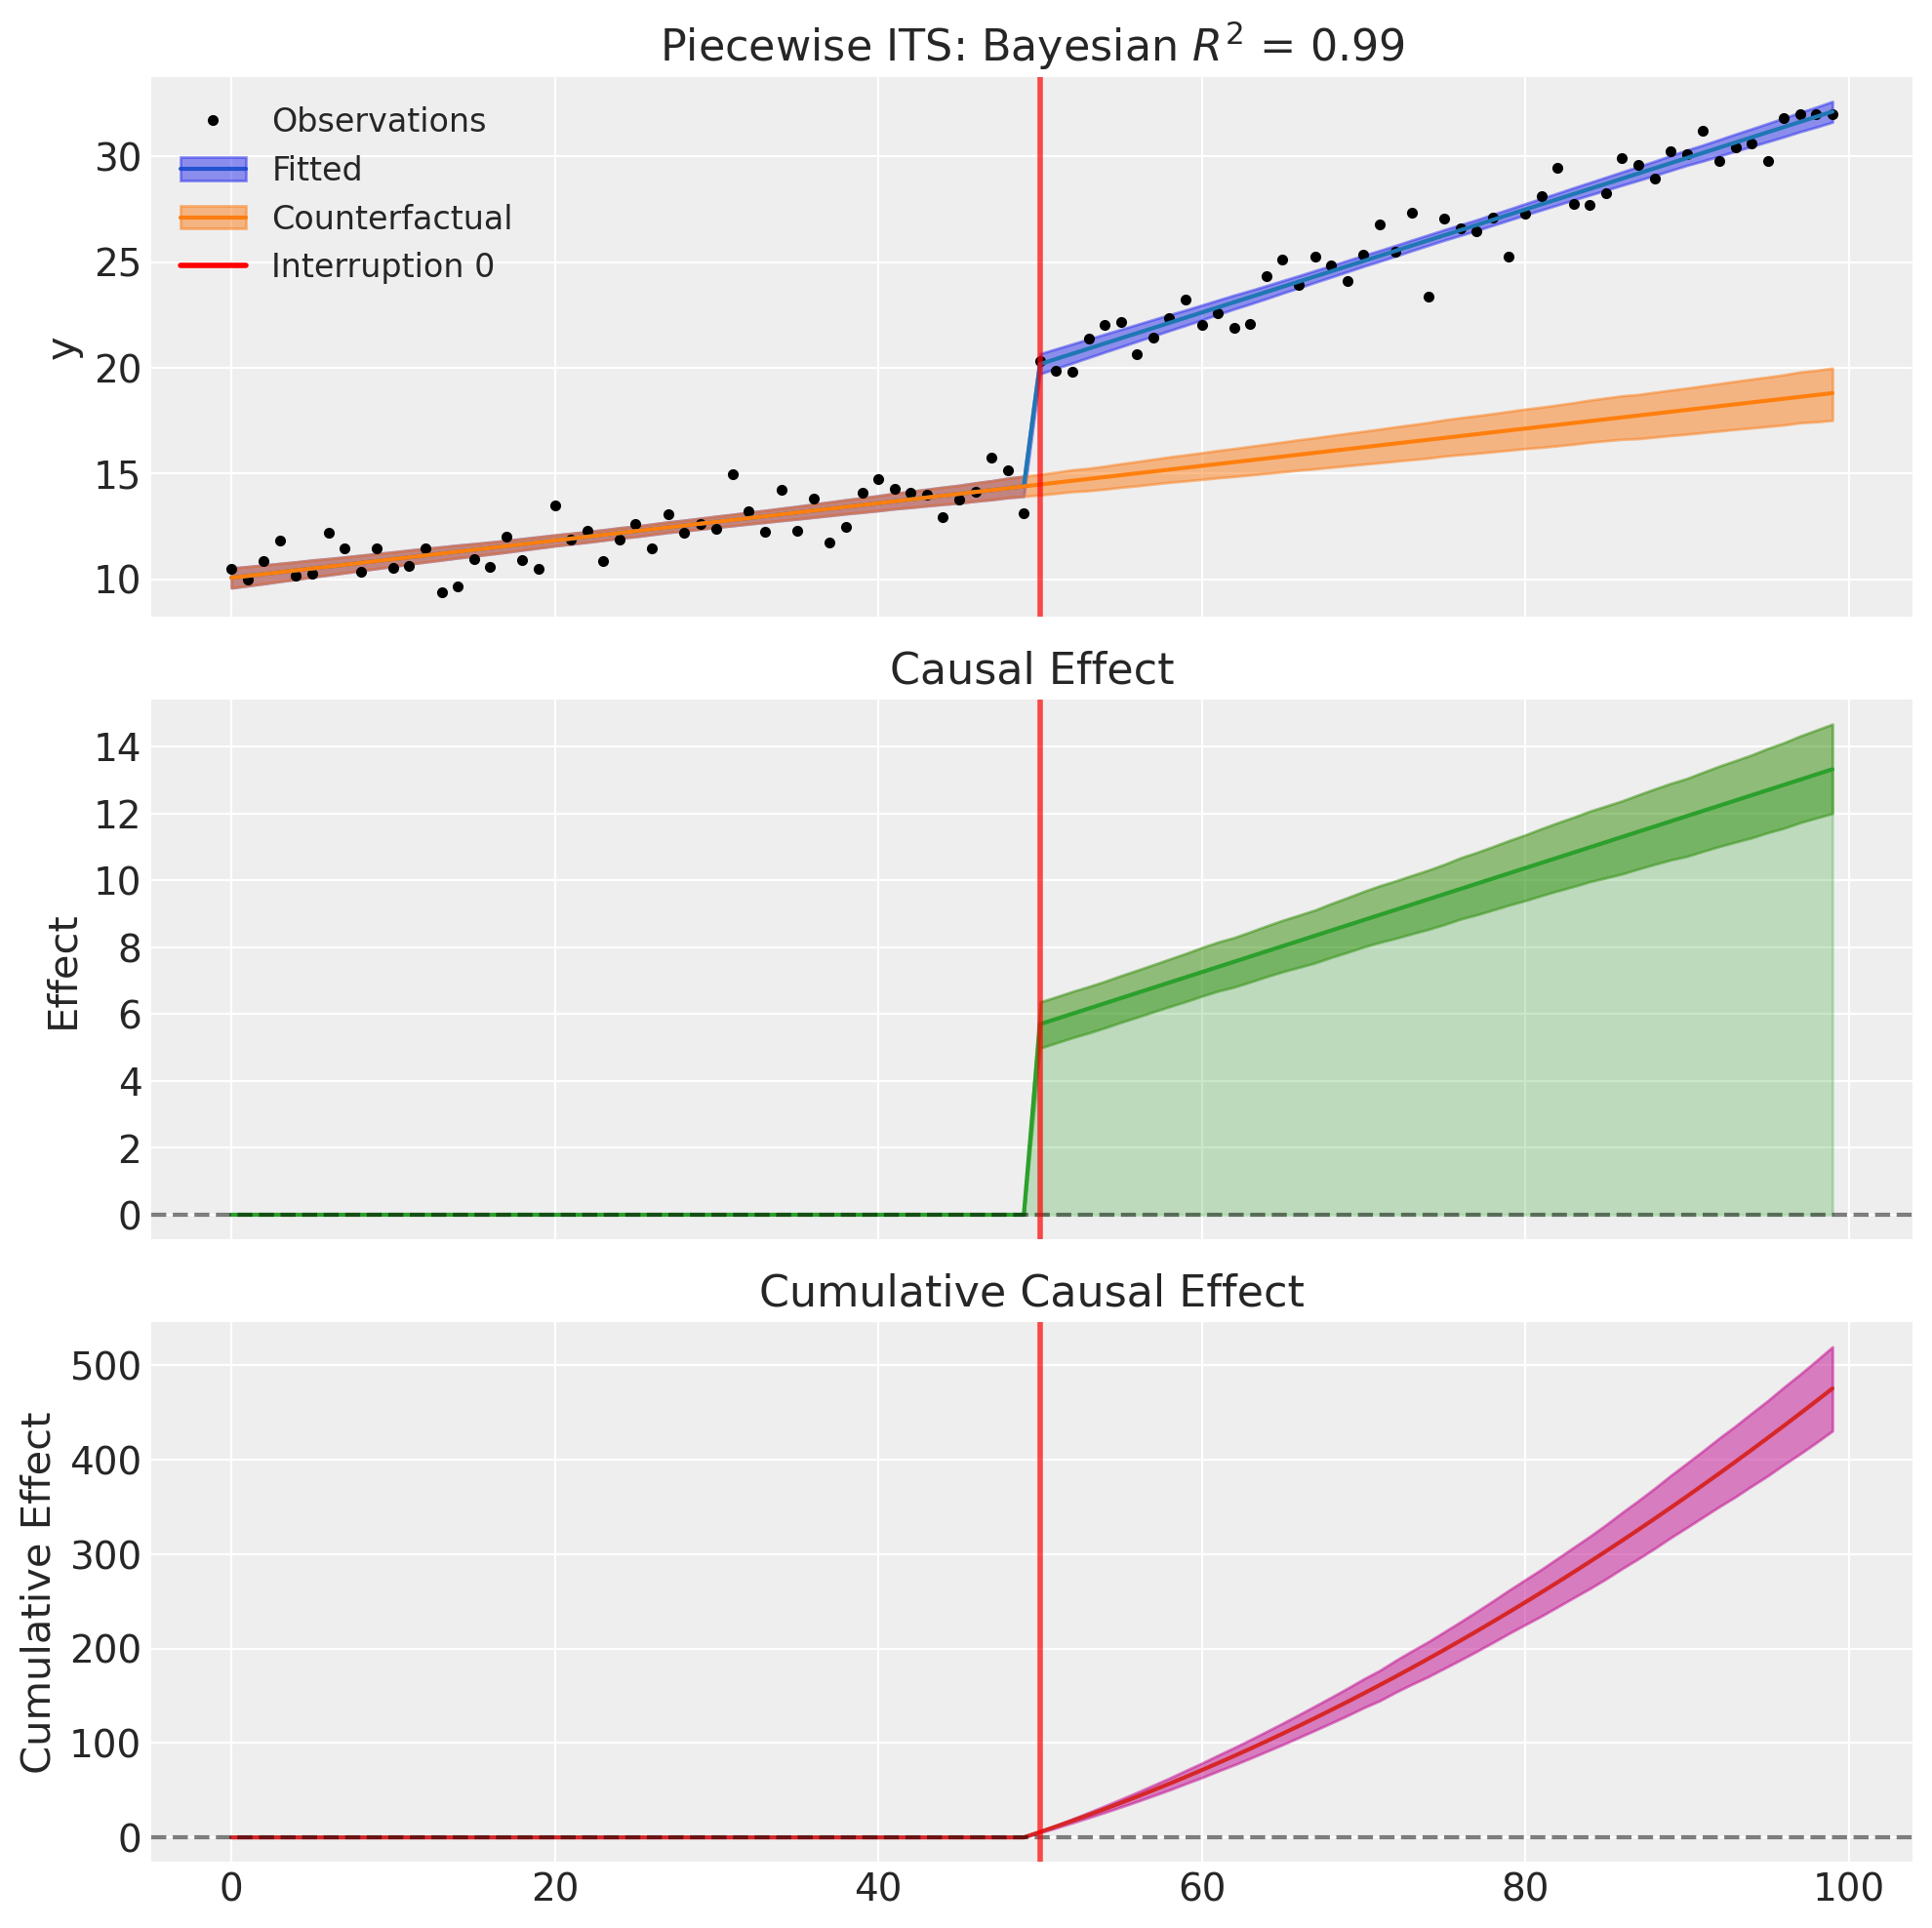

In [7]:
# Plot the results
fig, ax = result1.plot()

## Example 2: Multiple Interventions (2 Interruptions)

Real-world scenarios often involve multiple interventions over time. `PiecewiseITS` handles this naturally by adding step and ramp terms for each interruption.

:::{card} Scenario: Streaming Service Subscription Growth

Consider a streaming service tracking monthly subscriber counts over 150 weeks. Two major events occur during this period.

At week 50, the service launches a highly anticipated exclusive series. This creates an immediate level jump of about 4 million subscribers as fans sign up for the premiere, along with a steeper growth rate (increasing from the baseline of +0.08 million/week to +0.18 million/week) as word-of-mouth drives continued acquisition.

At week 100, a major competitor launches their own service with aggressive pricing. This causes an immediate level drop of about 3 million subscribers as some users switch, along with a flattened growth rate (a -0.12 million/week change that nearly offsets the earlier acceleration) as the market becomes more competitive.

This scenario demonstrates how Piecewise ITS can disentangle the effects of multiple interventions, estimating both immediate impacts and sustained changes for each event.
:::

We can capture this with the following formula:

```python
formula = "y ~ 1 + t + step(t, 50) + ramp(t, 50) + step(t, 100) + ramp(t, 100)"
```

Each intervention gets its own step and ramp term, allowing independent estimation of effects.


In [8]:
# Generate data with two interruptions
df2, params2 = generate_piecewise_its_data(
    N=150,
    interruption_times=[50, 100],
    baseline_intercept=10.0,
    baseline_slope=0.08,
    level_changes=[4.0, -3.0],  # First intervention increases, second decreases
    slope_changes=[0.1, -0.12],  # First steepens, second flattens
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params2['baseline_intercept']}")
print(f"  Baseline slope: {params2['baseline_slope']}")
print(f"  Level changes: {params2['level_changes']}")
print(f"  Slope changes: {params2['slope_changes']}")

True parameters:
  Baseline intercept: 10.0
  Baseline slope: 0.08
  Level changes: [4.0, -3.0]
  Slope changes: [0.1, -0.12]


In [9]:
# Fit the model
result2 = cp.PiecewiseITS(
    df2,
    formula="y ~ 1 + t + step(t, 50) + ramp(t, 50) + step(t, 100) + ramp(t, 100)",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [10]:
result2.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + t + step(t, 50) + ramp(t, 50) + step(t, 100) + ramp(t, 100)
Interruption times: [50, 100]
Model coefficients:
    Intercept     10, 94% HDI [9.6, 11]
    t             0.068, 94% HDI [0.051, 0.085]
    step(t, 50)   4.7, 94% HDI [4, 5.4]
    ramp(t, 50)   0.11, 94% HDI [0.081, 0.13]
    step(t, 100)  -2.8, 94% HDI [-3.6, -2.1]
    ramp(t, 100)  -0.12, 94% HDI [-0.14, -0.091]
    y_hat_sigma   0.95, 94% HDI [0.85, 1.1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


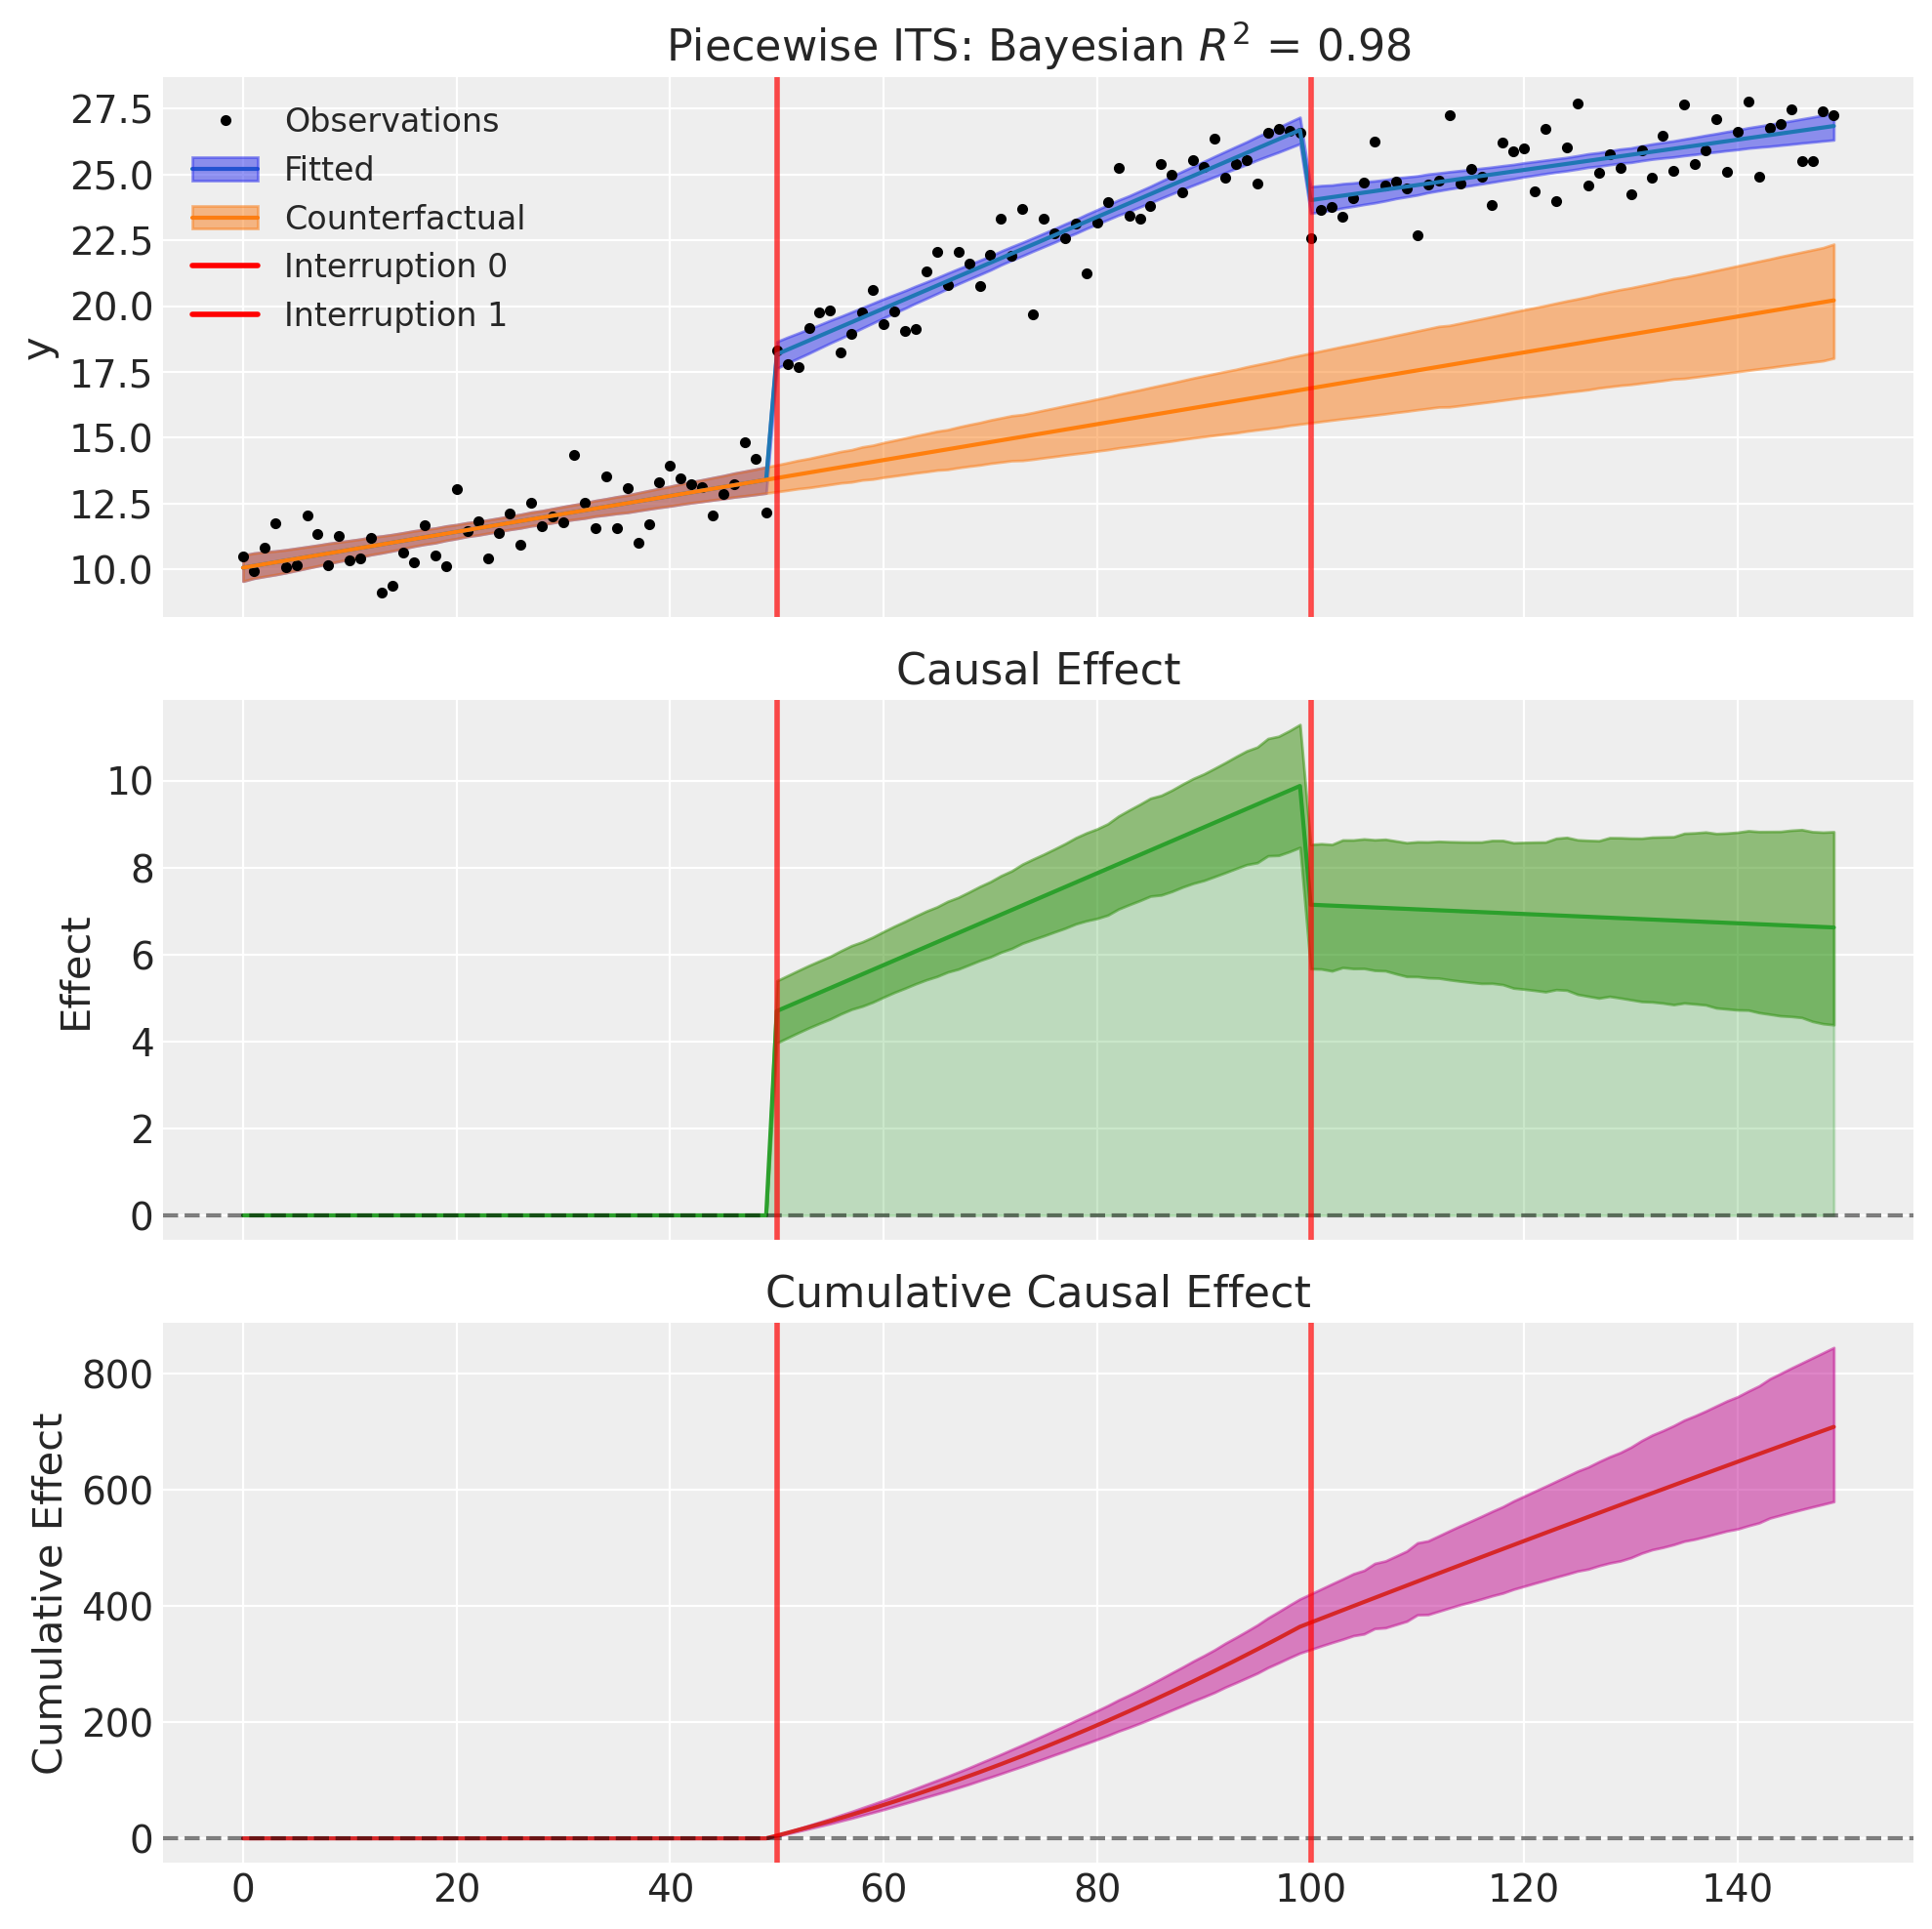

In [11]:
fig, ax = result2.plot()

## Example 3: Level Changes Only (Multiple Baseline Shifts)

Some interventions cause immediate level shifts but don't change the underlying trend. This is appropriate when interventions have instantaneous effects that persist at a constant level, without altering the rate of change over time.

:::{card} Scenario: Retail Store Foot Traffic
Consider a retail chain tracking daily foot traffic at a flagship store over 150 days. The store experiences a slow, steady natural growth in visitors (about 0.05% per day) as the neighborhood develops.

At day 50, a major anchor tenant (a popular restaurant) opens next door. This creates an immediate jump in foot traffic of about 8% as shoppers combine trips. However, the rate of growth doesn't change—the neighborhood development continues at the same pace.

At day 100, the anchor tenant closes unexpectedly due to lease issues. Foot traffic drops immediately by about 4%, losing some of the spillover benefit. Again, the underlying growth trend remains unchanged.

This "level-only" model is appropriate here because the interventions have instantaneous, discrete effects (the restaurant opens or closes on a specific day), the effects persist at a constant level (the spillover benefit doesn't grow or shrink over time), and the underlying trend is unaffected (neighborhood development continues regardless).
:::

We model this by using only `step()` terms (no `ramp()` terms):

```python
formula = "y ~ 1 + t + step(t, 50) + step(t, 100)"
```


In [12]:
# Generate data with level changes only (no slope changes)
df3, params3 = generate_piecewise_its_data(
    N=150,
    interruption_times=[50, 100],
    baseline_intercept=20.0,
    baseline_slope=0.05,
    level_changes=[8.0, -4.0],  # Two level shifts: up then partially down
    slope_changes=[0.0, 0.0],  # No slope changes
    noise_sigma=1.5,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params3['baseline_intercept']}")
print(f"  Baseline slope: {params3['baseline_slope']}")
print(f"  Level changes: {params3['level_changes']}")
print(f"  Slope changes: {params3['slope_changes']} (no trend breaks)")

True parameters:
  Baseline intercept: 20.0
  Baseline slope: 0.05
  Level changes: [8.0, -4.0]
  Slope changes: [0.0, 0.0] (no trend breaks)


In [13]:
# Fit with level changes only (no slope changes)
result3 = cp.PiecewiseITS(
    df3,
    formula="y ~ 1 + t + step(t, 50) + step(t, 100)",  # Only step terms, no ramp
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [14]:
result3.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + t + step(t, 50) + step(t, 100)
Interruption times: [50, 100]
Model coefficients:
    Intercept     20, 94% HDI [19, 20]
    t             0.04, 94% HDI [0.025, 0.055]
    step(t, 50)   8.9, 94% HDI [8, 9.8]
    step(t, 100)  -3.6, 94% HDI [-4.5, -2.7]
    y_hat_sigma   1.4, 94% HDI [1.3, 1.6]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


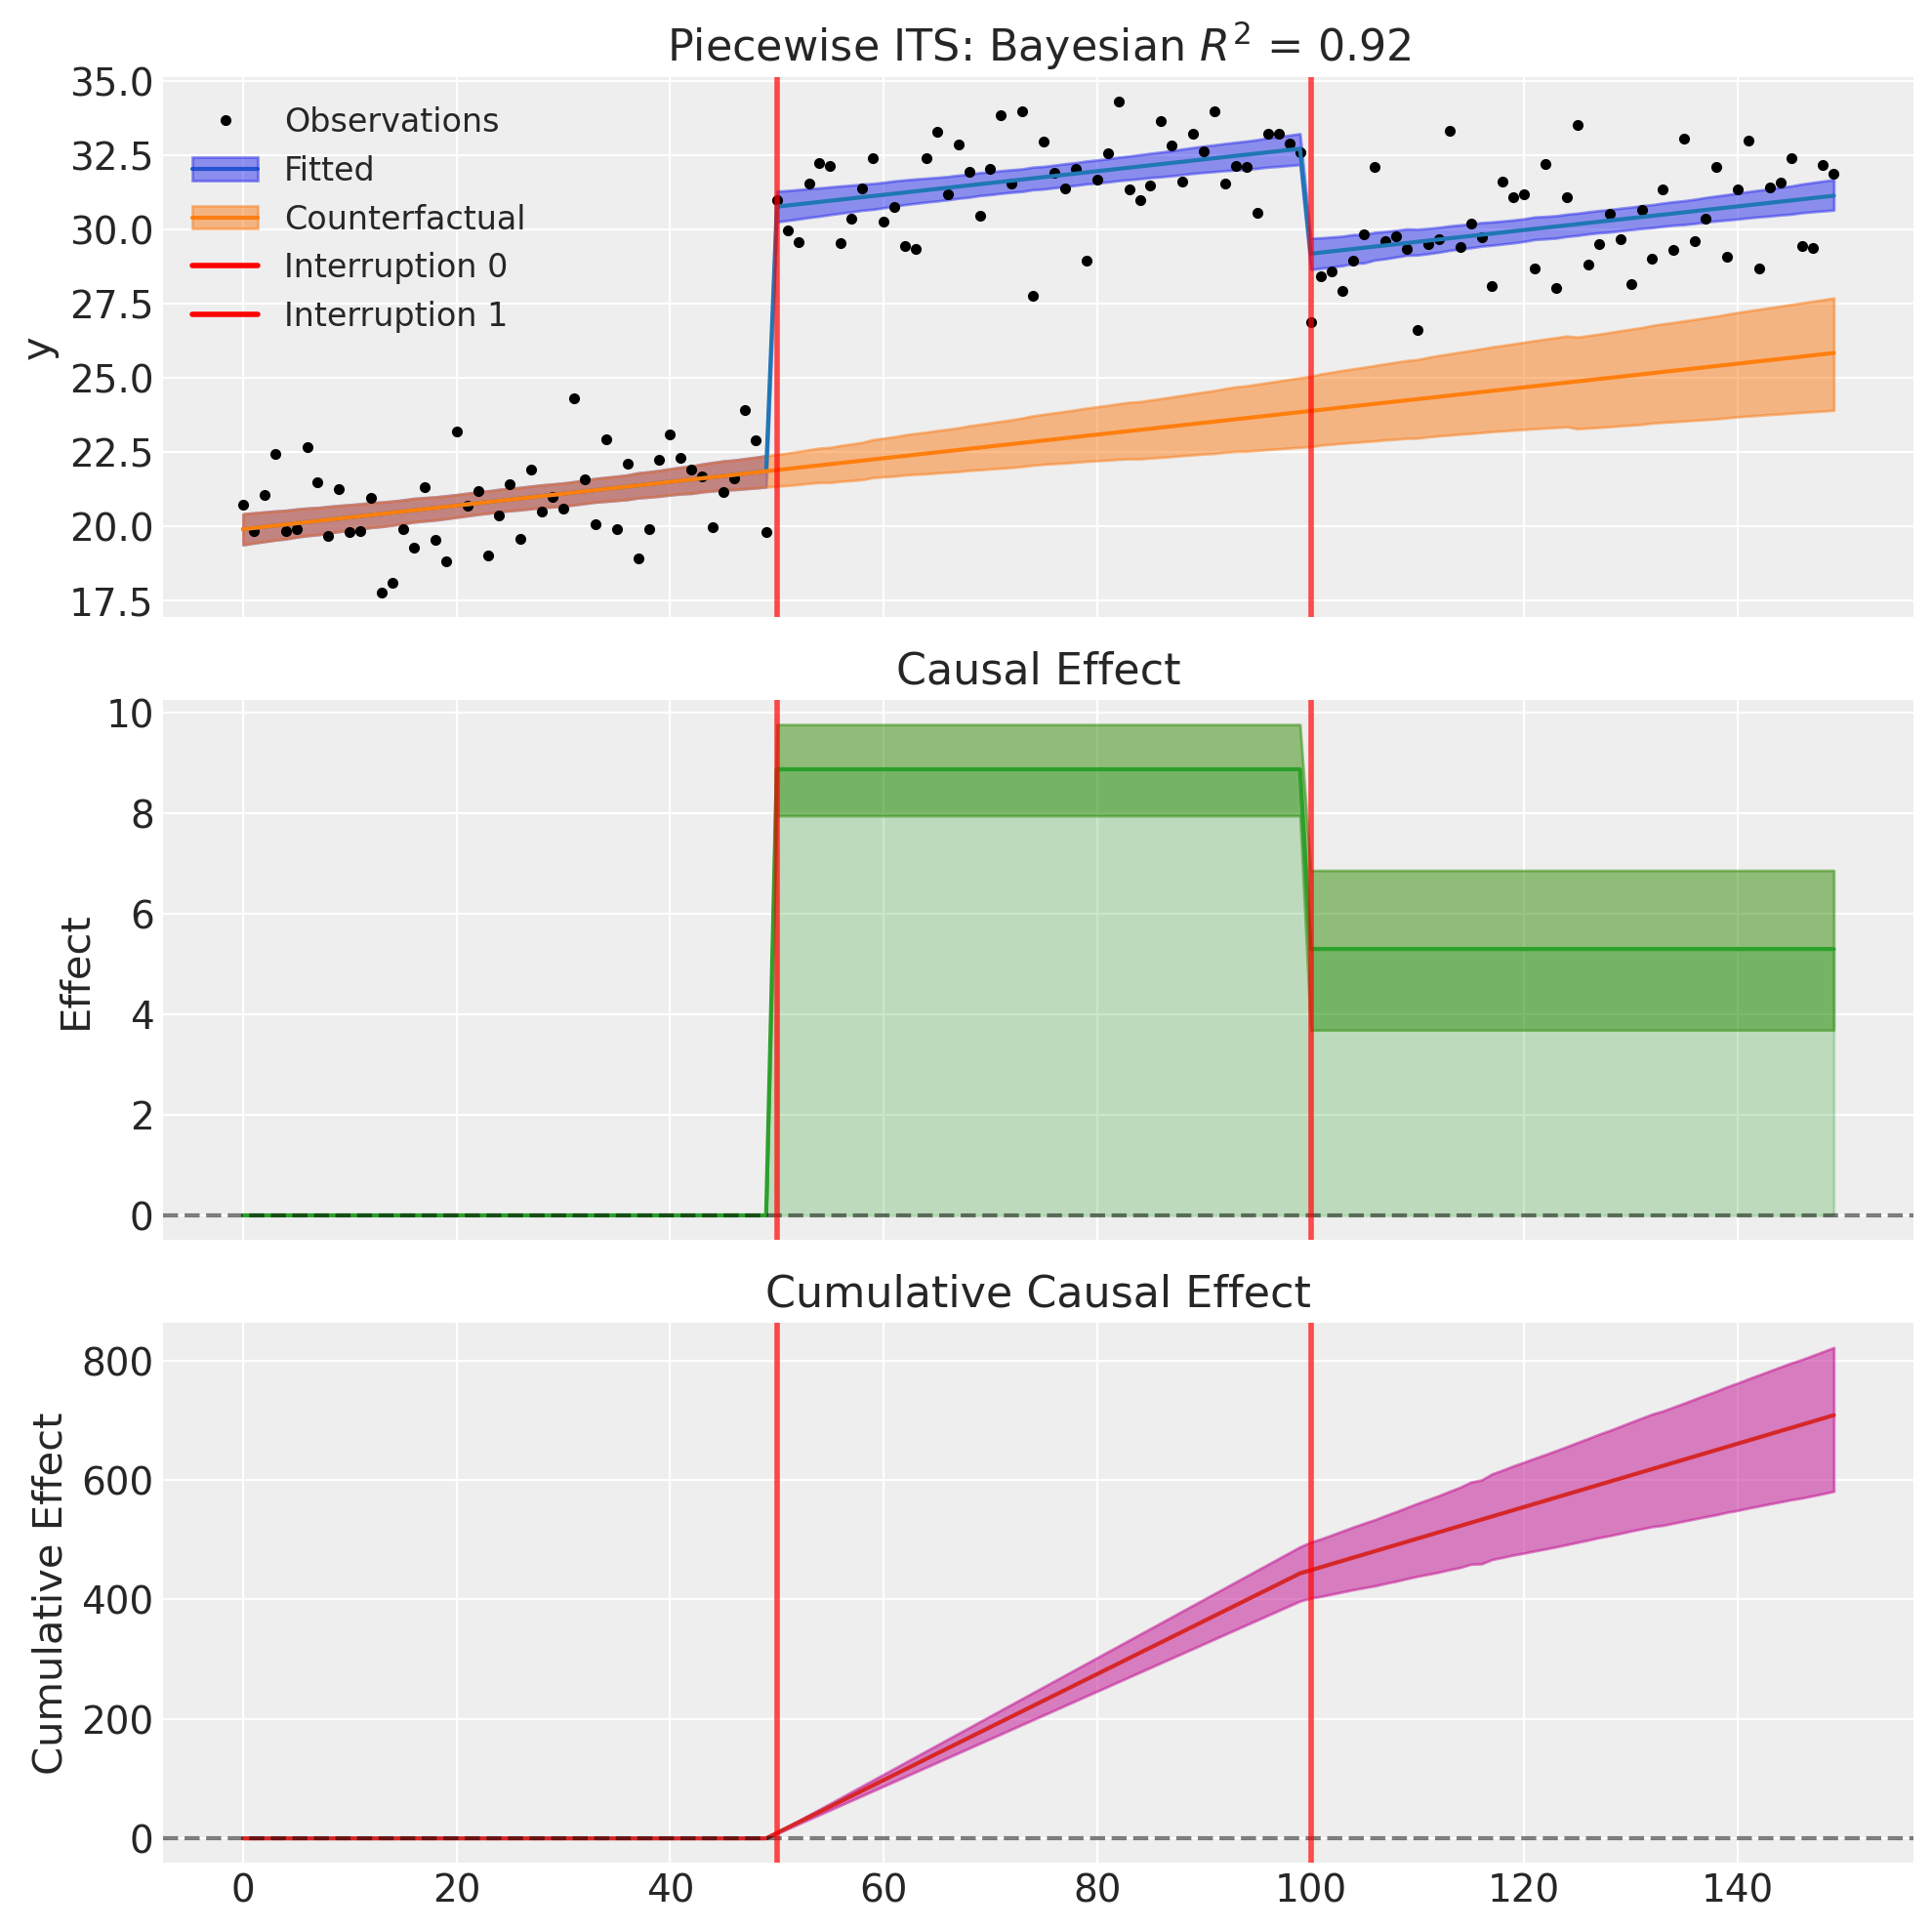

In [15]:
fig, ax = result3.plot()

## Example 4: Slope Changes Only (Multiple Trend Breaks)

Some interventions change the trajectory without an immediate effect. This is appropriate when interventions gradually alter the rate of change rather than causing instantaneous jumps.

:::{card} Scenario: Manufacturing Productivity Score

Consider a factory tracking a daily productivity score (units produced per worker-hour) over 150 days. The baseline shows slow natural improvement of about +0.05 units per day as workers gain experience through learning-by-doing.

At day 50, the factory implements a new skills training program. Critically, this doesn't immediately boost productivity—workers need time to learn and apply new techniques. Instead, we observe an accelerated improvement rate: productivity now increases by an additional +0.15 units per day as workers internalize the training and discover efficiencies.

At day 100, budget cuts force a reduction in ongoing training and mentorship. This doesn't cause an immediate productivity drop (skills already learned are retained), but the improvement rate slows by 0.10 units per day as workers can no longer learn new techniques as quickly.

This "slope-only" model is appropriate here because the interventions don't have immediate effects (training takes time to show results, and reduced investment doesn't instantly hurt productivity), the effects accumulate over time (each day after training the benefit grows, and each day after cuts the learning slowdown compounds), and we're modeling changes in trajectory rather than discrete events.
:::

We model this by using only `ramp()` terms (no `step()` terms):

```python
formula = "y ~ 1 + t + ramp(t, 50) + ramp(t, 100)"
```

Note that with slope-only changes, the causal effect starts at zero at the intervention time and grows (or shrinks) over time as the slope change accumulates.


In [16]:
# Generate data with slope changes only (no level shifts)
df4, params4 = generate_piecewise_its_data(
    N=150,
    interruption_times=[50, 100],
    baseline_intercept=15.0,
    baseline_slope=0.05,
    level_changes=[0.0, 0.0],  # No immediate shifts
    slope_changes=[0.15, -0.10],  # Two trend breaks: acceleration then deceleration
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params4['baseline_intercept']}")
print(f"  Baseline slope: {params4['baseline_slope']}")
print(f"  Level changes: {params4['level_changes']} (no immediate shifts)")
print(f"  Slope changes: {params4['slope_changes']}")

True parameters:
  Baseline intercept: 15.0
  Baseline slope: 0.05
  Level changes: [0.0, 0.0] (no immediate shifts)
  Slope changes: [0.15, -0.1]


In [17]:
# Fit with slope changes only (no level shifts)
result4 = cp.PiecewiseITS(
    df4,
    formula="y ~ 1 + t + ramp(t, 50) + ramp(t, 100)",  # Only ramp terms, no step
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [18]:
result4.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + t + ramp(t, 50) + ramp(t, 100)
Interruption times: [50, 100]
Model coefficients:
    Intercept     15, 94% HDI [14, 15]
    t             0.049, 94% HDI [0.035, 0.062]
    ramp(t, 50)   0.16, 94% HDI [0.13, 0.18]
    ramp(t, 100)  -0.11, 94% HDI [-0.13, -0.084]
    y_hat_sigma   0.95, 94% HDI [0.85, 1.1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


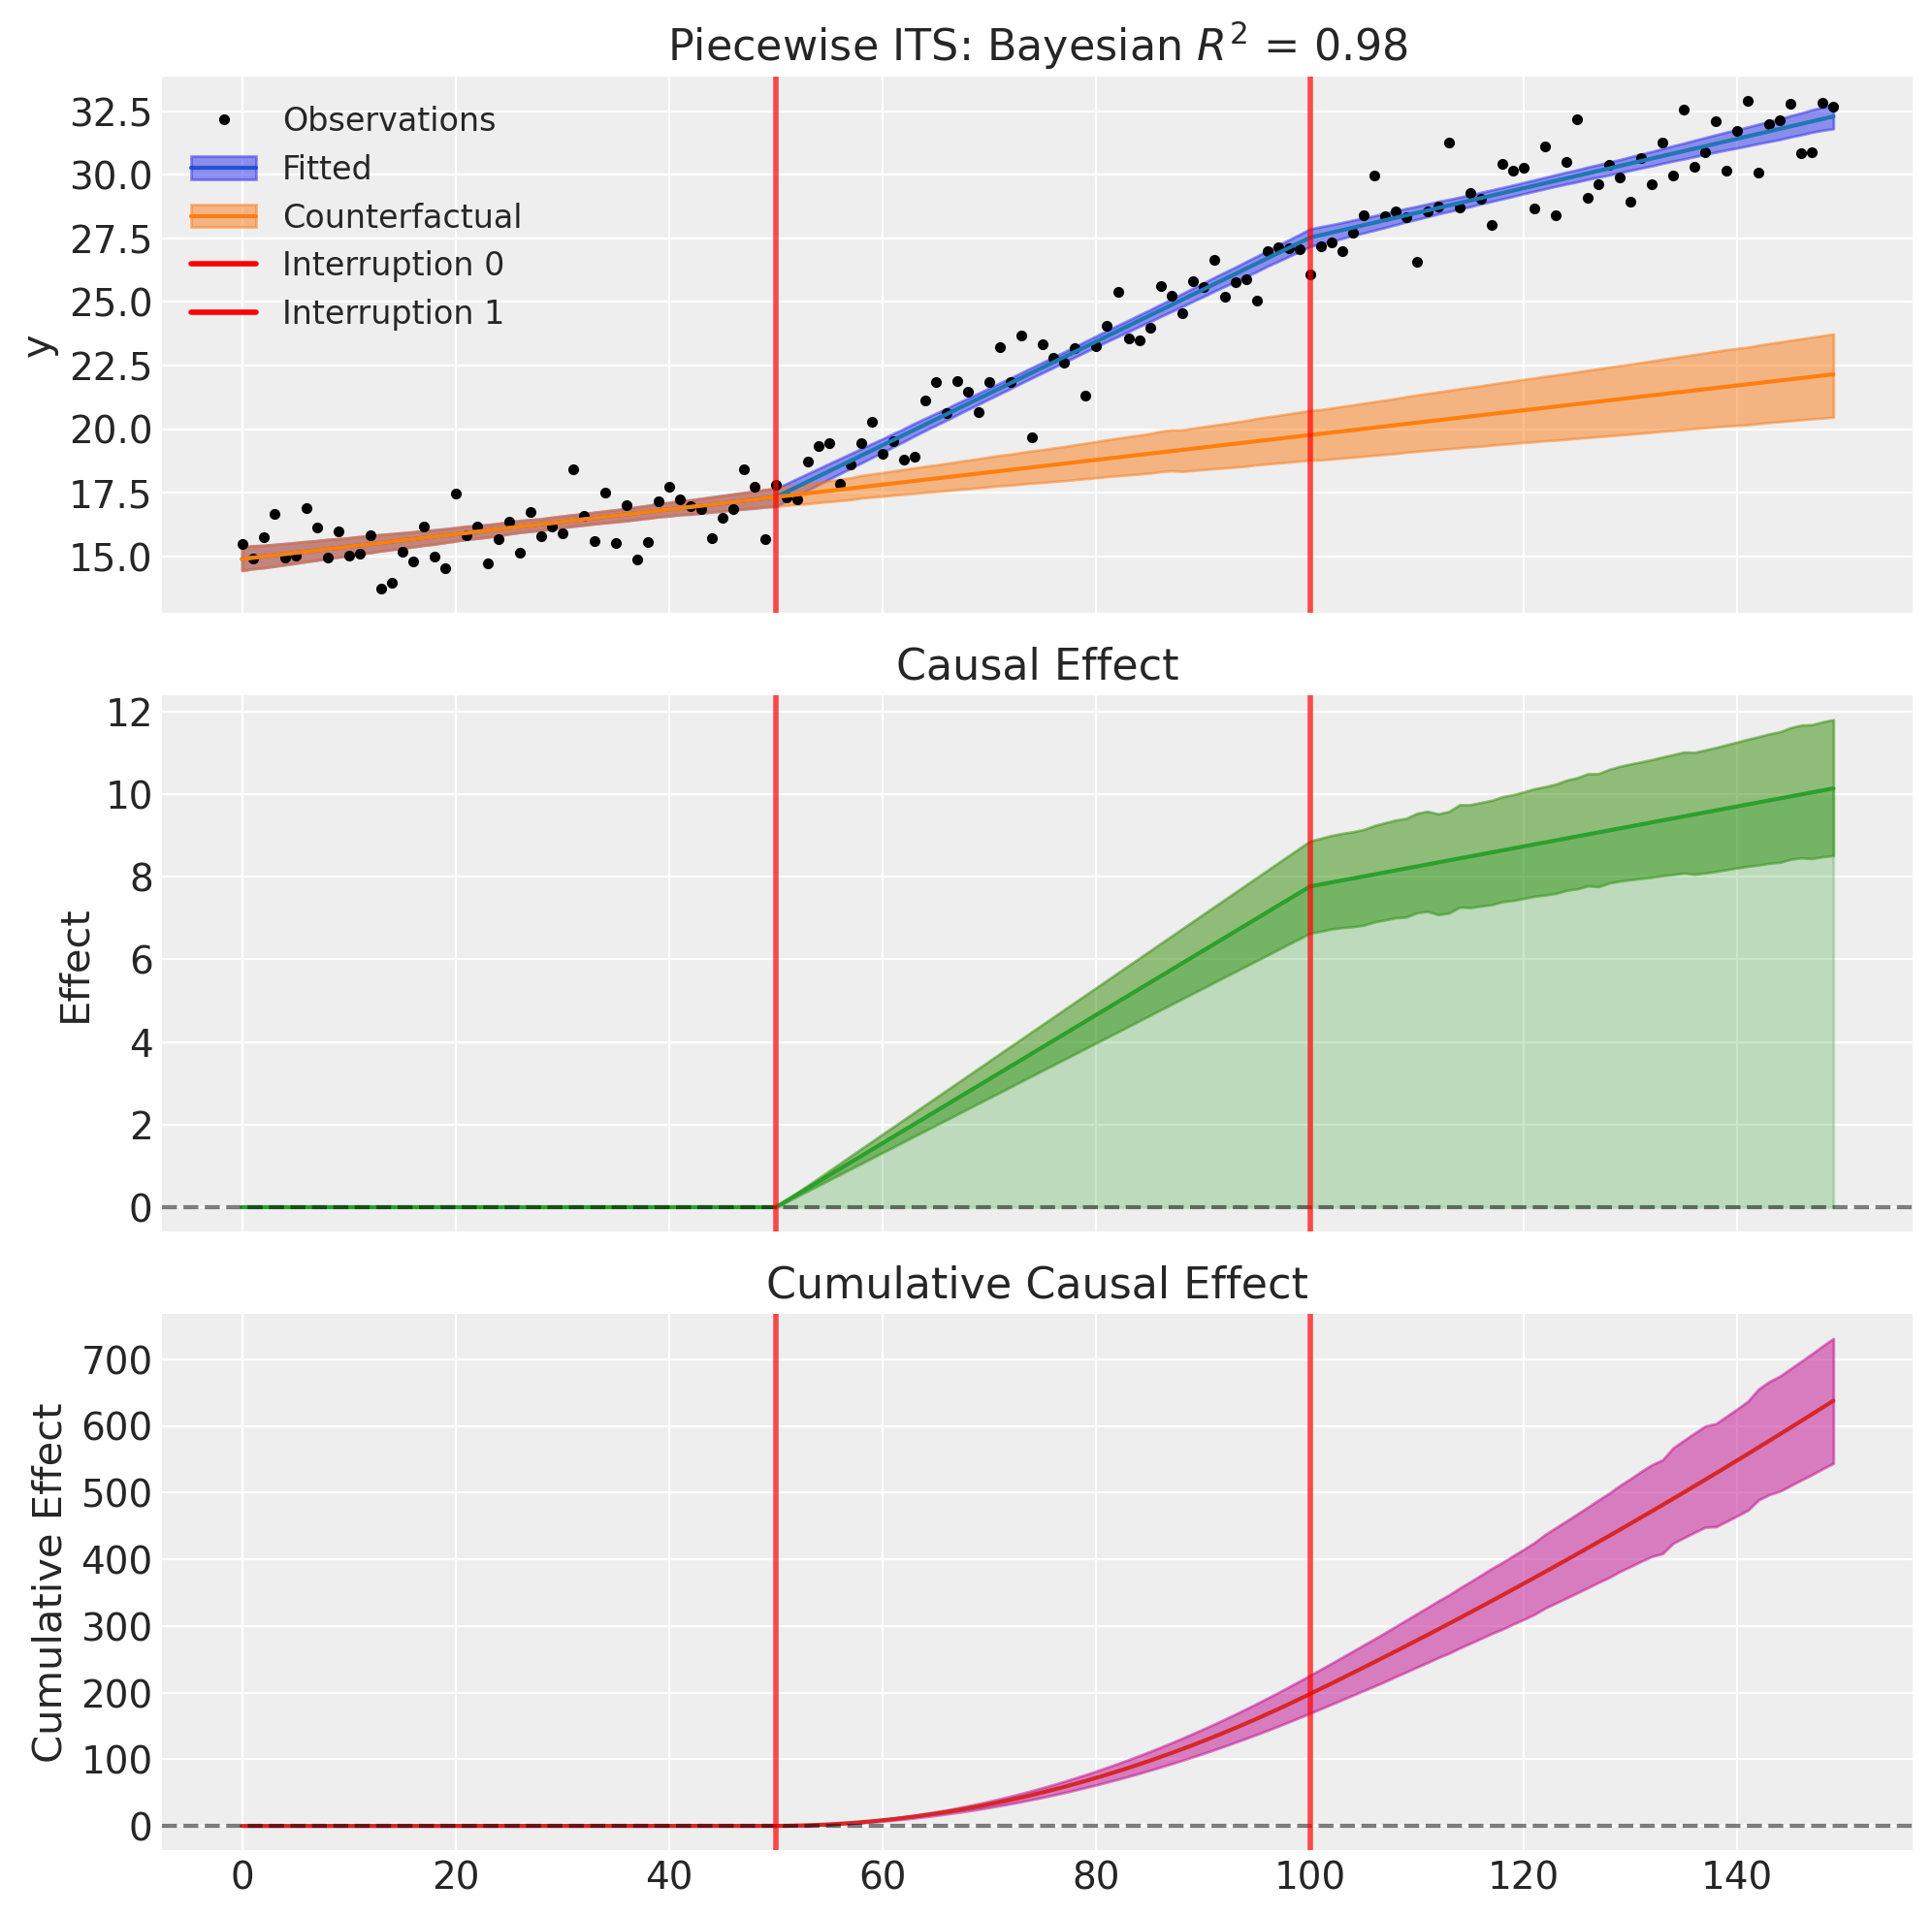

In [19]:
fig, ax = result4.plot()

Notice that the causal effect starts at zero at the first intervention time (t=50) and grows linearly as the first slope change accumulates. At the second intervention (t=100), the rate of effect accumulation changes again—in this case, the effect continues to grow but at a slower rate as the second (negative) slope change partially offsets the first.


## Example 5: Mixed Effects Per Intervention (Key Flexibility)

One of the main advantages of the formula-based API is the ability to specify **different effects for different interventions**. This isn't possible with a simple boolean flag approach.

:::{card} Scenario: City Transportation Policy

Consider a city tracking average commute times over 150 weeks. Two interventions occur:

**At week 50**: A new express bus route opens. This causes an **immediate level drop** in commute times (people switch to the faster route), but no sustained slope change (the route is immediately at full capacity).

**At week 100**: A congestion pricing scheme is introduced. This causes **both** an immediate level drop (some drivers switch to off-peak hours or transit) **and** a sustained slope improvement (as more people gradually adapt their behavior over time).
:::

We can capture this with the following formula:
```python
# Different effects per intervention!
formula = "y ~ 1 + t + step(t, 50) + step(t, 100) + ramp(t, 100)"
```

Note that:
- Intervention 1 (t=50): Only `step()` - level change only
- Intervention 2 (t=100): Both `step()` and `ramp()` - level and slope change


In [20]:
# Generate data with mixed effects
df5, params5 = generate_piecewise_its_data(
    N=150,
    interruption_times=[50, 100],
    baseline_intercept=60.0,  # Starting commute time in minutes
    baseline_slope=0.02,  # Slow increase due to traffic growth
    level_changes=[-5.0, -3.0],  # Both interventions reduce commute time
    slope_changes=[0.0, -0.05],  # Only second intervention changes slope
    noise_sigma=1.5,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params5['baseline_intercept']}")
print(f"  Baseline slope: {params5['baseline_slope']}")
print(f"  Level changes: {params5['level_changes']}")
print(f"  Slope changes: {params5['slope_changes']}")

True parameters:
  Baseline intercept: 60.0
  Baseline slope: 0.02
  Level changes: [-5.0, -3.0]
  Slope changes: [0.0, -0.05]


In [21]:
# Fit with different effects per intervention
result5 = cp.PiecewiseITS(
    df5,
    formula="y ~ 1 + t + step(t, 50) + step(t, 100) + ramp(t, 100)",  # Mixed!
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [22]:
result5.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + t + step(t, 50) + step(t, 100) + ramp(t, 100)
Interruption times: [50, 100]
Model coefficients:
    Intercept     60, 94% HDI [59, 61]
    t             0.0068, 94% HDI [-0.011, 0.026]
    step(t, 50)   -4, 94% HDI [-5.1, -2.9]
    step(t, 100)  -2.7, 94% HDI [-3.6, -1.7]
    ramp(t, 100)  -0.04, 94% HDI [-0.073, -0.0085]
    y_hat_sigma   1.4, 94% HDI [1.3, 1.6]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


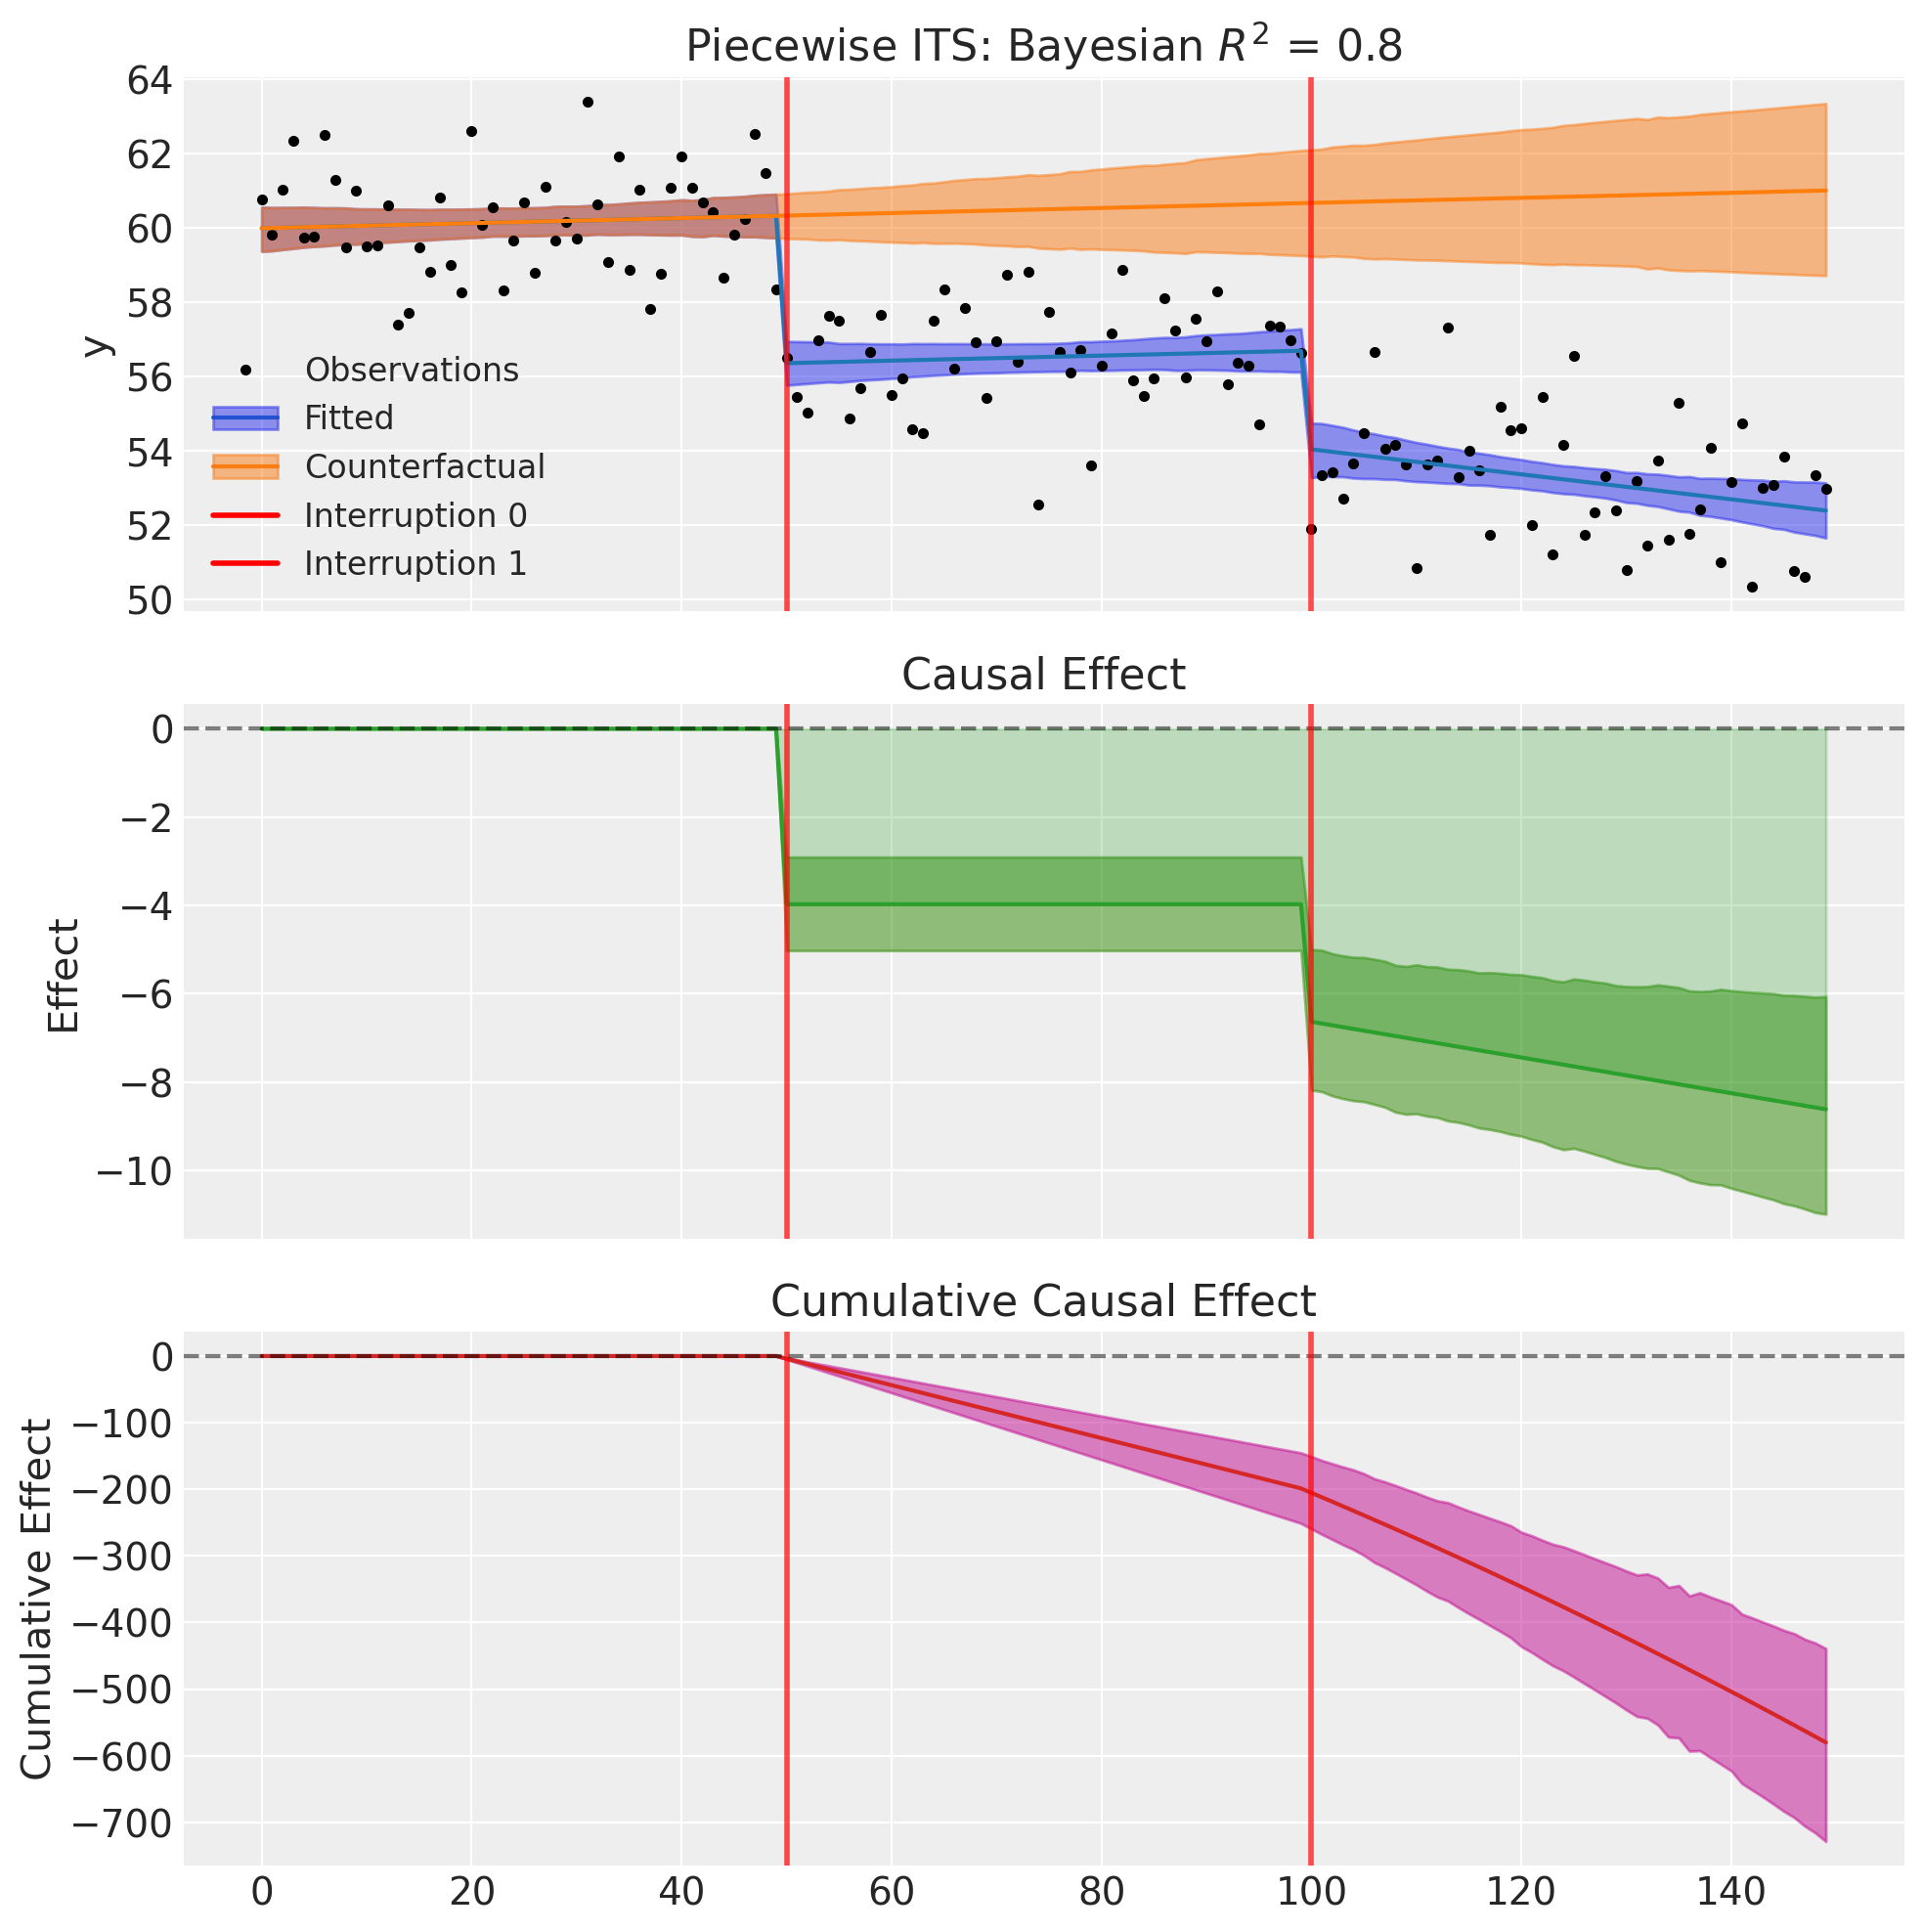

In [23]:
fig, ax = result5.plot()

## Example 6: Using Datetime Thresholds

The `step()` and `ramp()` transforms work seamlessly with datetime time columns. Simply specify the threshold as a date string:

```python
formula = "y ~ 1 + step(date, '2020-06-01') + ramp(date, '2020-06-01')"
```

The transforms automatically handle datetime conversion internally, expressing ramp values in days.


In [24]:
# Create data with datetime index
import pandas as pd

np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=150, freq="D")
t_numeric = np.arange(150)
y = (
    100
    + 0.1 * t_numeric
    + 5 * (t_numeric >= 50)
    + 0.15 * np.maximum(0, t_numeric - 50)
    + np.random.randn(150) * 2
)

df_datetime = pd.DataFrame({"date": dates, "y": y})

# Fit using datetime thresholds
result6 = cp.PiecewiseITS(
    df_datetime,
    formula="y ~ 1 + step(date, '2020-02-20') + ramp(date, '2020-02-20')",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [25]:
result6.summary()

=======================Piecewise Interrupted Time Series========================
Formula: y ~ 1 + step(date, '2020-02-20') + ramp(date, '2020-02-20')
Interruption times: ['2020-02-20']
Model coefficients:
    Intercept                 102, 94% HDI [101, 103]
    step(date, '2020-02-20')  8.2, 94% HDI [7.2, 9.1]
    ramp(date, '2020-02-20')  0.25, 94% HDI [0.23, 0.26]
    y_hat_sigma               2, 94% HDI [1.8, 2.2]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:539: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


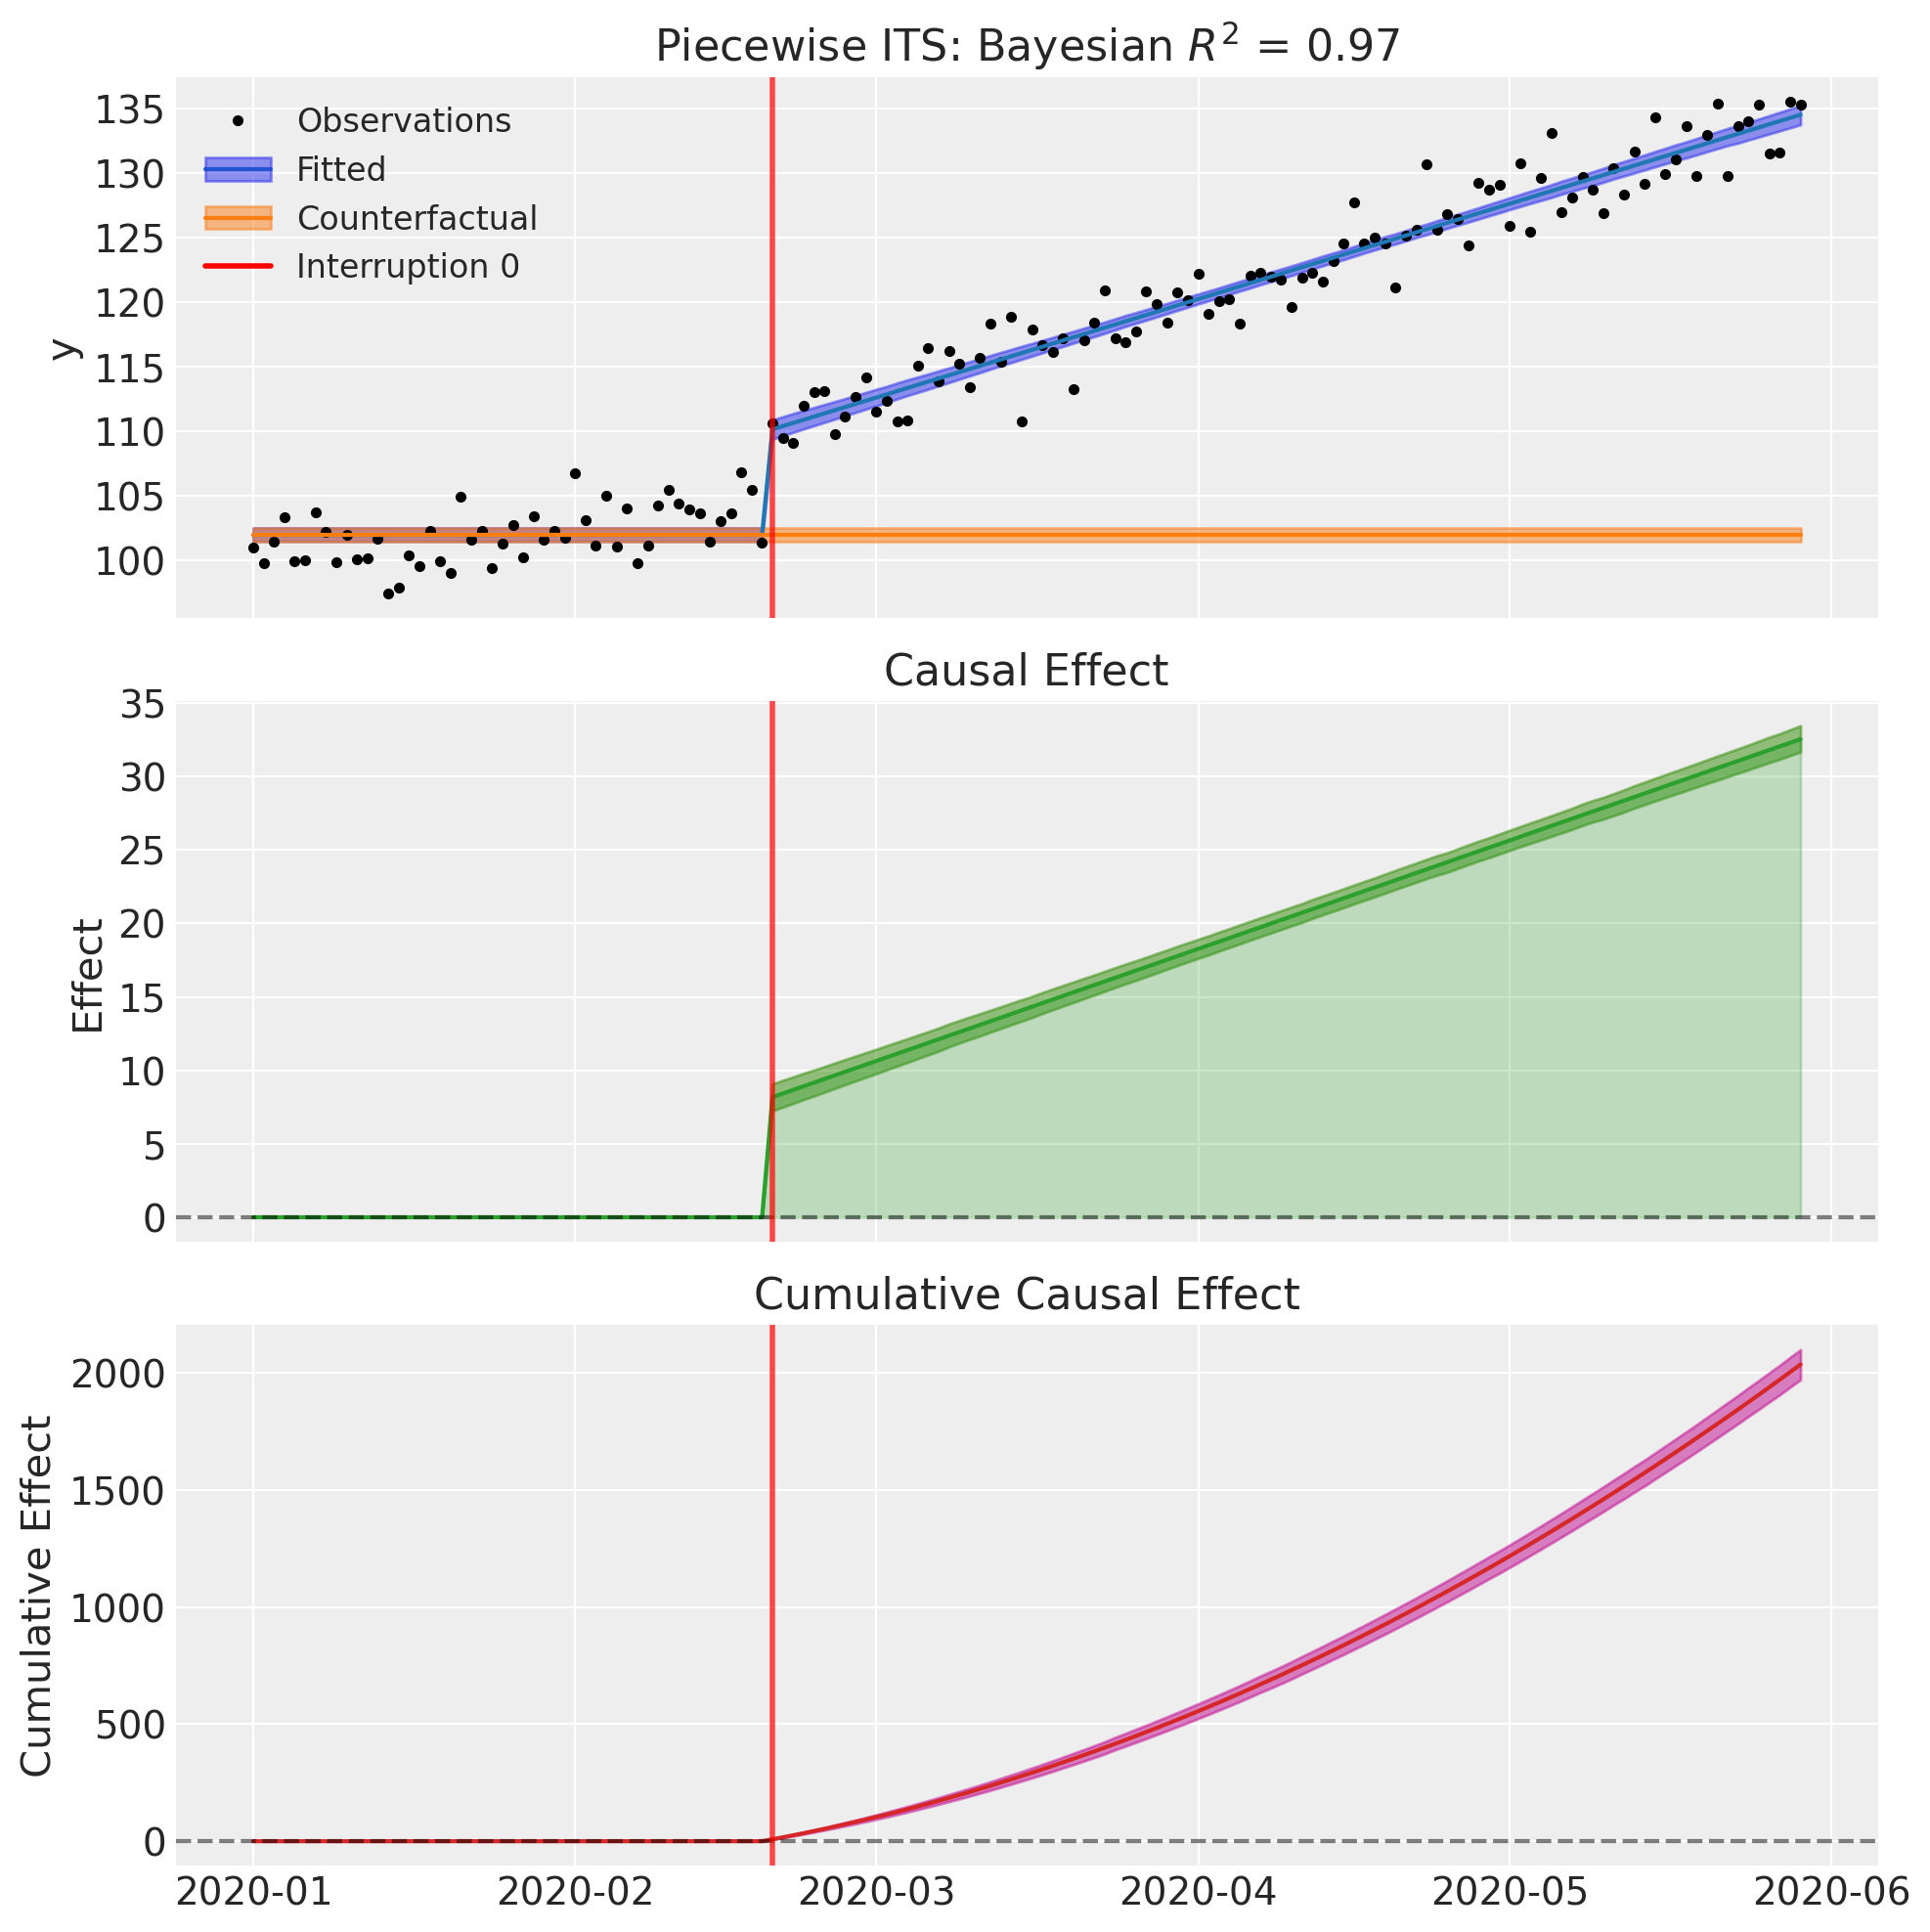

In [26]:
fig, ax = result6.plot()

## References

- Wagner AK, Soumerai SB, Zhang F, Ross-Degnan D. (2002). Segmented regression analysis of interrupted time series studies in medication use research. Journal of Clinical Pharmacy and Therapeutics, 27(4):299-309.
- Lopez Bernal J, Cummins S, Gasparrini A. (2017). Interrupted time series regression for the evaluation of public health interventions: a tutorial. International Journal of Epidemiology, 46(1):348-355.
- Kontopantelis E, Doran T, Springate DA, Buchan I, Reeves D. (2015). Regression based quasi-experimental approach when randomisation is not an option: interrupted time series analysis. BMJ, 350:h2750.
